# Step 4: Analysis
**[➤➤ VIEW ON NBVIEWER](https://nbviewer.org/github/wikimedia-research/cws-historical-metrics/blob/main/04-analysis.ipynb)**
- Report at: https://meta.wikimedia.org/wiki/Community_Wishlist_Survey/Historical_Metrics_2023
- Appendix: https://meta.wikimedia.org/wiki/Community_Wishlist_Survey/Historical_Metrics_2023/Appendix

## Setup

In [11]:
import pandas as pd
import duckdb
from tabulate import tabulate as tbl

import json
import warnings

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

pd.options.display.max_columns = None
pd.options.display.max_rows = 100

from IPython.display import display_html, display, HTML

In [61]:
init_notebook_mode(connected=True)
iplot_width = 950
iplot_config = {'displayModeBar': True}

pd.options.display.max_columns = None
pd.options.display.max_rows = 500

In [19]:
# connect to database
conn = duckdb.connect('secrets/cws_data.db')

# query function, returns dataframe if needed
def query(query_string, df=False, conn=conn):
    if df==True:
        return conn.sql(query_string).df()
    else:
        return conn.sql(query_string).show()

In [14]:
## close connection
conn.close()

In [15]:
# display dataframes horizontally
# optional main title, and bold if needed
# define number of dataframes per row (default: 3)
def display_dfs_parallel(frames, 
                       title=None, 
                       bold_title=False, 
                       title_font_size=18, 
                       group_size=3,
                       df_title_bold=False,
                       df_title_font_size=14):

    groups = [list(frames.items())[i:i + group_size] for i in range(0, len(frames), group_size)]
    
    if title:
        title_html = f"<b>{title}</b>" if bold_title else title
        display(HTML(f"<div style='text-align:center; font-size: {title_font_size}px;'>{title_html}</div>"))
    
    for group in groups:
        html = ""
        for key, df in group:
            df_heading_style = "font-weight: bold;" if df_title_bold else ""
            html_df = f'<div style="margin-right: 10px;"><h4 style="text-align:center; font-size: {df_title_font_size}px; {df_heading_style}">{key}</h4>{df._repr_html_()}</div>'
            html += html_df

        html_group = f"""
        <div style="display:flex; justify-content: space-evenly; flex-wrap: wrap;">
        {html}
        </div>"""

        display_html(html_group, raw=True)


# dataframe to MediaWiki table
def df_to_mwtable(df):
    print(tbl(df, headers=df.columns, tablefmt='mediawiki'))

In [16]:
# calculate percentage or cumilative percentage for a dataframe column
def perc_cumsum(df, column, csum=True):
    df['percent'] = round(df[column] / df[column].sum() * 100, 2)
    
    if csum == True:
        df['perc_csum'] = df['percent'].cumsum()
        return df
    else:
        return df
    
# save figure as SVG
def save_fig(fig, title):
    if '.svg' in title:
        fig.write_image(f'charts/{title}')
    else:
        fig.write_image(f'charts/{title}.svg')

## Analysis

### Proposals by year

In [20]:
# accepted proposals

conn.sql("""
CREATE OR REPLACE VIEW accepted_proposals AS
SELECT
    p.year,
    p.category,
    p.proposal
FROM
    proposals p
    LEFT JOIN rejects r
    ON p.year = r.year AND p.proposal = r.proposal
WHERE 
    r.proposal IS NULL 
    AND category NOT IN ('Untranslated', 'Larger_suggestions')
""")

#### All proposals

In [21]:
all_proposals = conn.sql("""
WITH
    base AS (
        SELECT
            *,
            'no_err' AS error
        FROM
            proposals
        UNION ALL
        SELECT
            *
        FROM
            errors
    )

SELECT
    year,
    COUNT(DISTINCT proposal) AS all_proposals,
    COUNT(DISTINCT CASE WHEN NOT error = 'no_err' THEN proposal END) AS all_errors
FROM
    base
GROUP BY
    year
ORDER BY
    year
""").df()

all_proposals['perc_errors_all'] = round(all_proposals['all_errors'] / all_proposals['all_proposals'] * 100, 2)
display_dfs_parallel({'All Proposals by Year': all_proposals}, df_title_bold=True)

,year,all_proposals,all_errors,perc_errors_all
0,2015,107,0,0.00
1,2016,265,0,0.00
2,2017,329,6,1.82
3,2019,347,15,4.32
4,2020,122,4,3.28
5,2021,453,25,5.52
6,2022,467,16,3.43
7,2023,272,8,2.94


#### Accepted proposals

In [22]:
# accepted proposals by year

acc_proposals = conn.sql("""
WITH
    base AS (
        SELECT
            *,
            'no_err' AS error
        FROM
            accepted_proposals
        UNION ALL
        SELECT
            *
        FROM
            errors
    )

SELECT
    year,
    COUNT(DISTINCT proposal) AS accepted_proposals,
    COUNT(DISTINCT CASE WHEN NOT error = 'no_err' AND NOT category IN ('Archive', 'Large_suggestions') THEN proposal END) AS non_archive_errors
FROM
    base
GROUP BY
    year
ORDER BY
    year
""").df()

acc_proposals['perc_errors_acc'] = round(acc_proposals['non_archive_errors'] / acc_proposals['accepted_proposals'] * 100, 2)
display_dfs_parallel({'Accepted Proposals by Year': acc_proposals}, df_title_bold=True)

,year,accepted_proposals,non_archive_errors,perc_errors_acc
0,2015,107,0,0.00
1,2016,265,0,0.00
2,2017,219,1,0.46
3,2019,224,2,0.89
4,2020,76,0,0.00
5,2021,292,1,0.34
6,2022,279,8,2.87
7,2023,188,3,1.60


In [23]:
acc_err_pct = round(acc_proposals.non_archive_errors.sum() / acc_proposals.accepted_proposals.sum() * 100, 2)
print(f'Error rate for accepted proposals {acc_err_pct}%')

Error rate for accepted proposals 0.91%


#### Merge user data for accepted proposals

In [24]:
# create a merged view of accepted proposals with user data

conn.sql("""
CREATE OR REPLACE VIEW ud_merge AS
SELECT
    ap.*,
    role,
    r.username,
    home_wiki,
    db_group AS hw_db_group,
    hw_user_groups AS hw_user_groups,
    edit_bucket,
    account_age,
    wiki_name,
    size_rank,
    lang_name
FROM
    accepted_proposals ap
    JOIN roles r ON ap.year = r.year AND ap.proposal = r.proposal
    JOIN user_data ud ON r.year = ud.year AND r.username = ud.username
    JOIN cdw ON ud.home_wiki = cdw.wiki_db
""")

In [11]:
proposals_summary = pd.merge(all_proposals, acc_proposals, on='year')
proposals_summary['rejection_rate'] = round((1 - proposals_summary['accepted_proposals'] /  proposals_summary['all_proposals']) * 100, 2)
display_dfs_parallel({'Proposals summary': proposals_summary}, df_title_bold=True)

,year,all_proposals,all_errors,perc_errors_all,accepted_proposals,non_archive_errors,perc_errors_acc,rejection_rate
0,2015,107,0,0.00,107,0,0.00,0.00
1,2016,265,0,0.00,265,0,0.00,0.00
2,2017,329,6,1.82,219,1,0.46,33.43
3,2019,347,15,4.32,224,2,0.89,35.45
4,2020,122,4,3.28,76,0,0.00,37.70
5,2021,453,25,5.52,292,1,0.34,35.54
6,2022,467,16,3.43,279,8,2.87,40.26
7,2023,272,8,2.94,188,3,1.60,30.88


In [13]:
print(f'Average number of proposals by year {proposals_summary.all_proposals.mean()}')

Average number of proposals by year 295.25


#### Proposals by year: Line graph

In [12]:
# prepare dataframe for plotting
proposals_summary_melt = pd.melt(proposals_summary, 'year', 
        ['all_proposals', 'accepted_proposals'], 
        'Status', 'Number of proposals')

proposals_summary_melt = proposals_summary_melt.replace({
    'all_proposals': 'All proposals', 
    'accepted_proposals': 'Accepted proposals'
})

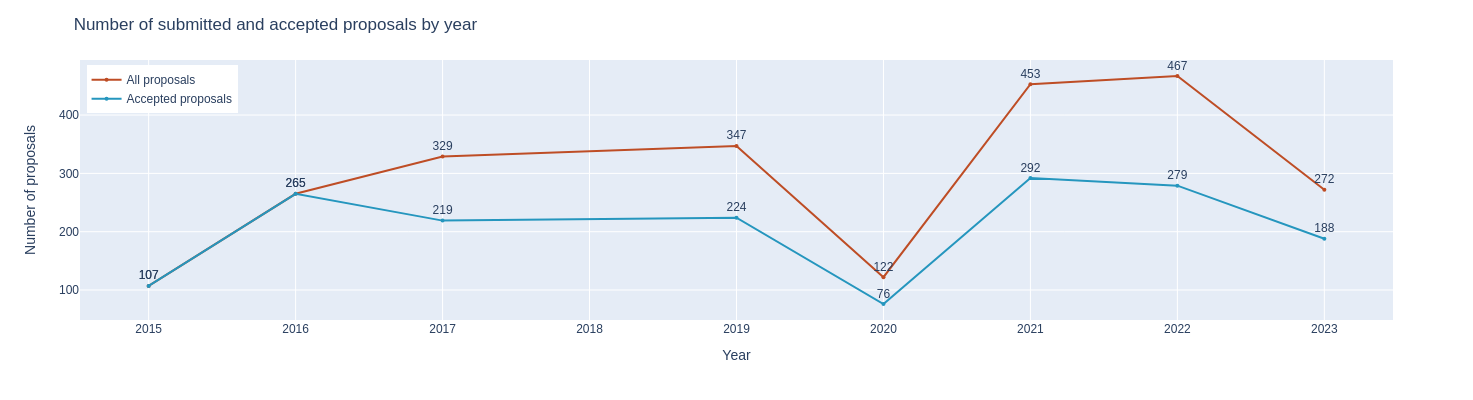

In [13]:
# proposals_summary_melt['label'] = proposals_summary_melt['Number of proposals'].astype(str)

fig = px.line(proposals_summary_melt, 
              x='year', 
              y='Number of proposals', 
              color='Status',
              text='Number of proposals',
              labels={'year': 'Year'},
              color_discrete_map={'All proposals': '#be4d25', 'Accepted proposals': '#2596be'},
              width=800, height=400)

fig.update_traces(mode='lines+markers+text',
                 textposition='top center',
                 marker=dict(size=4))

fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.98,
        xanchor="left",
        x=0.005,
        title={'text': None}
    ),
    title=dict(text='Number of submitted and accepted proposals by year')
)

iplot(fig, config=iplot_config)

In [14]:
print(f'rejection rate: {round(proposals_summary.query("""year >= 2017""").rejection_rate.mean())}%')

rejection rate: 36%


In [38]:
fig.write_image('charts/proposals_by_year.svg')

### Categories by year

In [25]:
categories_by_year = query("""
WITH 
    base AS (
        SELECT 
            *, 
            NULL AS error 
        FROM 
            accepted_proposals
        UNION ALL
        SELECT 
            * 
        FROM 
            errors),

    yearly AS (
        SELECT
            year, 
            category, 
            COUNT(DISTINCT proposal) AS proposals 
        FROM 
            base
        WHERE
            NOT category IN ('Archive', 'Larger_suggestions', 'Untranslated')
        GROUP BY 
            year, 
            category)

PIVOT yearly
ON category
USING SUM(proposals)
GROUP BY year
""", True).fillna(0).astype(int)

display_dfs_parallel({'Number of proposals in each category by year': categories_by_year}, df_title_bold=True)

,year,Anti-harassment,Bots_and_gadgets,Citations,Communication_tools,Editing,Maps,Miscellaneous,Mobile_and_apps,Moderation_tools,Multimedia_and_Commons,Navigation_tools,New_contributors,Programs_and_events,Reading,Templates,Translation,Watchlists,WikiProjects,Wikibooks,Wikidata,Wikinews,Wikiquote,Wikisource,Wikispecies,Wikiversity,Wikivoyage,Wiktionary
0,2015,0,4,0,9,13,0,17,0,13,11,12,0,0,4,3,0,7,0,0,7,0,0,6,0,1,0,0
1,2016,0,13,6,0,34,0,34,10,22,44,11,0,7,10,0,0,24,2,0,26,0,0,18,0,0,0,4
2,2017,3,10,5,0,25,0,27,18,13,29,8,0,2,13,0,0,15,0,0,29,0,0,9,0,0,0,8
3,2019,4,10,13,4,27,13,17,12,15,20,18,0,2,8,0,0,12,0,0,19,0,0,11,0,0,0,7
4,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,3,28,1,11,4,20
5,2021,3,15,12,7,39,0,27,18,25,31,21,0,0,13,0,10,17,0,0,21,0,0,5,0,0,0,4
6,2022,11,13,11,6,34,0,39,17,11,27,18,0,0,14,0,15,10,0,0,26,0,0,11,0,0,0,7
7,2023,9,10,5,15,21,0,20,3,16,27,8,3,0,11,0,8,0,0,0,14,0,0,6,0,0,0,6


In [28]:
proposals_by_category = pd.DataFrame(categories_by_year.query("""year !=2020""").set_index('year').sum()).rename({0: 'proposals'}, axis=1).sort_values('proposals', ascending=False)
display_dfs_parallel({'Proposals by categories': perc_cumsum(proposals_by_category.drop('Miscellaneous'), 'proposals')}, df_title_bold=True)

,proposals,percent,perc_csum
Editing,193,14.44,14.44
Multimedia_and_Commons,189,14.14,28.58
Wikidata,142,10.62,39.20
Moderation_tools,115,8.60,47.80
Navigation_tools,96,7.18,54.98
Watchlists,85,6.36,61.34
Mobile_and_apps,78,5.83,67.17
Bots_and_gadgets,75,5.61,72.78
Reading,73,5.46,78.24
Wikisource,66,4.94,83.18


In [18]:
display_dfs_parallel({
    'Unique categories by year': query(
        """
        SELECT 
            year, 
            COUNT(DISTINCT category) AS distinct_categories 
        FROM 
            accepted_proposals 
        GROUP BY 
            year""", 
        True
    )}, df_title_bold=True)

,year,distinct_categories
0,2015,13
1,2016,15
2,2022,16
3,2023,16
4,2017,15
5,2019,17
6,2020,8
7,2021,16


In [100]:
proposals_2020 = (categories_by_year
                  .query("""year == 2020""")
                  .set_index('year')
                  .melt(var_name='category', value_name='proposals')
                  .query("""proposals > 0""")
                  .sort_values('proposals', ascending=False)
                  .set_index('category'))

display_dfs_parallel({'Proposals and categories (for 2020) - Top 3': perc_cumsum(proposals_2020.head(3), 'proposals')}, df_title_bold=True)

,proposals,percent,perc_csum
category,,,
Wikisource,28,47.46,47.46
Wiktionary,20,33.90,81.36
Wikiversity,11,18.64,100.00


#### Top five categories

In [29]:
top5_categories = proposals_by_category.iloc[:5, :].index.tolist()
top5_categories_by_year = categories_by_year.loc[:, ['year'] + top5_categories].query("""year != 2020""")

display_dfs_parallel({'Top five categories (and number of proposals) by year': top5_categories_by_year.set_index('year')}, df_title_bold=True)

,Editing,Multimedia_and_Commons,Miscellaneous,Wikidata,Moderation_tools
year,,,,,
2015,13,11,17,7,13
2016,34,44,34,26,22
2017,25,29,27,29,13
2019,27,20,17,19,15
2021,39,31,27,21,25
2022,34,27,39,26,11
2023,21,27,20,14,16


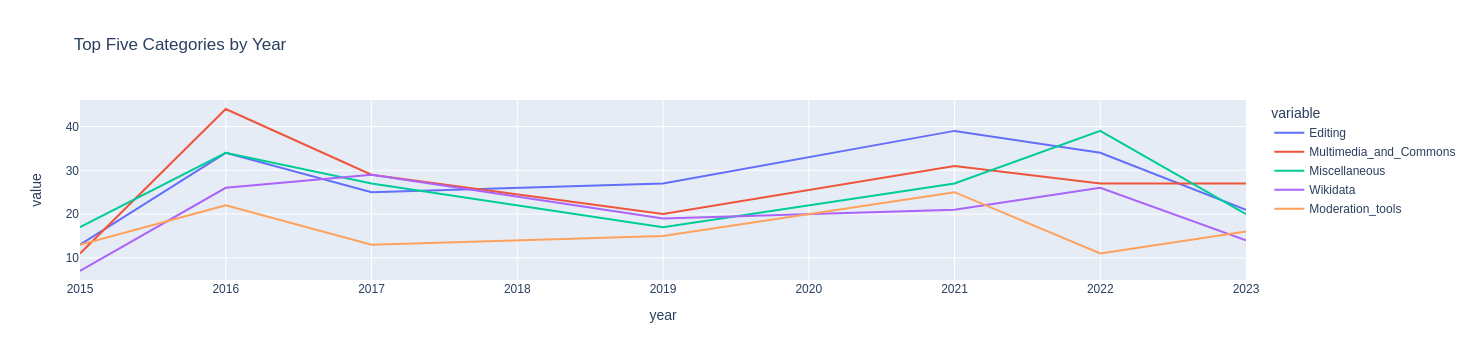

In [21]:
fig = px.line(top5_categories_by_year, 
              x='year', 
              y=['Editing', 'Multimedia_and_Commons', 'Miscellaneous', 'Wikidata', 'Moderation_tools'], 
              width=iplot_width, title='Top Five Categories by Year')

iplot(fig, config=iplot_config)

#### Top 6-10 categories

In [30]:
top10_categories = proposals_by_category.iloc[6:11, :].index.tolist()
top10_categories_by_year = categories_by_year.loc[:, ['year'] + top10_categories].query("""year != 2020""")
display_dfs_parallel({'Top 6-10 categories (and number of proposals) by year': top10_categories_by_year.set_index('year')}, df_title_bold=True)

,Watchlists,Mobile_and_apps,Bots_and_gadgets,Reading,Wikisource
year,,,,,
2015,7,0,4,4,6
2016,24,10,13,10,18
2017,15,18,10,13,9
2019,12,12,10,8,11
2021,17,18,15,13,5
2022,10,17,13,14,11
2023,0,3,10,11,6


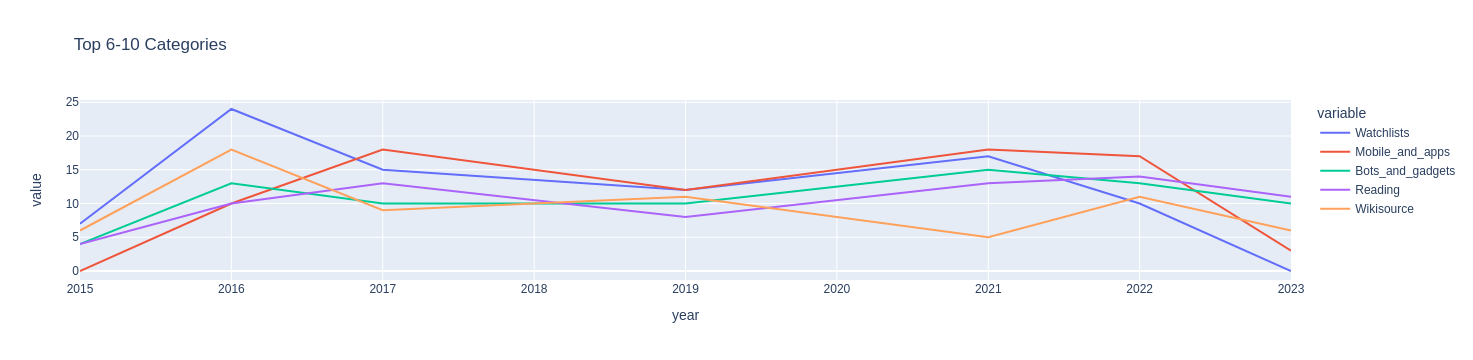

In [23]:
fig = px.line(
    top10_categories_by_year, 
    x='year', 
    y=['Watchlists', 'Mobile_and_apps', 'Bots_and_gadgets', 'Reading', 'Wikisource'], 
    width=iplot_width, 
    title='Top 6-10 Categories')

iplot(fig, config=iplot_config)

### Categories by participation

In [31]:
# participation from roles in various categories

roles_by_cy = query("""
SELECT
    year,
    category,
    role,
    COUNT(DISTINCT username) AS users
FROM
    ud_merge
GROUP BY
    year,
    category,
    role
ORDER BY
    year,
    category,
    role
""", True)

In [32]:
# overall roles

overall_roles = query("""
SELECT
    category,
    role,
    COUNT(DISTINCT username) AS users
FROM
    ud_merge
WHERE
    NOT year = 2020
    AND NOT category = 'Miscellaneous'
GROUP BY
    category,
    role
ORDER BY
    category,
    role
""", True)

In [33]:
# rank category by participation for each role

def generate_ranks(filter_col, filter_var, rank_column, base_df):
    df = base_df[base_df[filter_col] == filter_var].sort_values(rank_column, ascending=False)
    df = perc_cumsum(df, rank_column).sort_values('percent', ascending=False, ignore_index=True)
    df = df.reset_index().rename({'index': f'{filter_var}_rank'}, axis=1)
    df[f'{filter_var}_rank'] = df[f'{filter_var}_rank'] + 1
    return df

In [95]:
proposers_by_category = generate_ranks('role', 'proposer', 'users', overall_roles)
display_dfs_parallel({'Top 10 categories of participation for proposers': proposers_by_category.head(10).drop(['proposer_rank', 'role'], axis=1)}, df_title_bold=True)

,category,users,percent,perc_csum
0,Editing,128,14.32,14.32
1,Multimedia_and_Commons,122,13.65,27.97
2,Wikidata,79,8.84,36.81
3,Moderation_tools,76,8.50,45.31
4,Navigation_tools,65,7.27,52.58
5,Watchlists,59,6.60,59.18
6,Mobile_and_apps,58,6.49,65.67
7,Reading,58,6.49,72.16
8,Bots_and_gadgets,55,6.15,78.31
9,Citations,38,4.25,82.56


In [96]:
discussants_by_category = generate_ranks('role', 'discussant', 'users', overall_roles)
display_dfs_parallel({'Top 10 categories of participation for discussants': discussants_by_category.head(10).drop(['discussant_rank', 'role'], axis=1)}, df_title_bold=True)

,category,users,percent,perc_csum
0,Editing,410,12.70,12.70
1,Multimedia_and_Commons,408,12.64,25.34
2,Moderation_tools,274,8.49,33.83
3,Wikidata,266,8.24,42.07
4,Reading,247,7.65,49.72
5,Bots_and_gadgets,216,6.69,56.41
6,Navigation_tools,205,6.35,62.76
7,Watchlists,199,6.16,68.92
8,Mobile_and_apps,193,5.98,74.90
9,Citations,163,5.05,79.95


In [94]:
voters_by_category = generate_ranks('role', 'voter', 'users', overall_roles)
display_dfs_parallel({'Top 10 categories of participation for voters': voters_by_category.head(10).drop(['voter_rank', 'role'], axis=1)}, df_title_bold=True)

,category,users,percent,perc_csum
0,Editing,1783,12.54,12.54
1,Moderation_tools,1283,9.03,21.57
2,Multimedia_and_Commons,1227,8.63,30.20
3,Bots_and_gadgets,1066,7.50,37.70
4,Reading,1019,7.17,44.87
5,Navigation_tools,1001,7.04,51.91
6,Wikidata,928,6.53,58.44
7,Citations,857,6.03,64.47
8,Mobile_and_apps,816,5.74,70.21
9,Anti-harassment,768,5.40,75.61


#### Heat map of categories by participation from various roles, across years

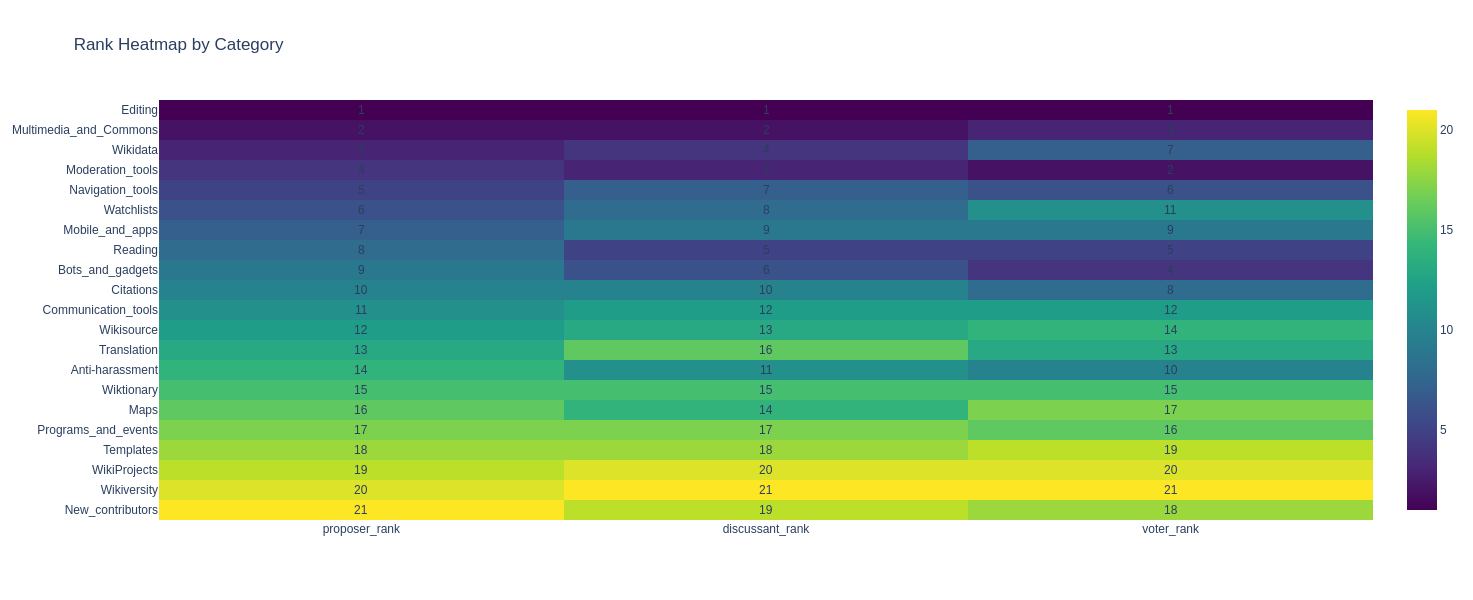

In [42]:
roles_ranking = (
    pd
    .merge(
        pd
        .merge(
            proposers_by_category.iloc[:, :2], 
            discussants_by_category.iloc[:, :2], 
            on='category'), 
        voters_by_category.iloc[:, :2], 
        on='category')
).sort_values(by='proposer_rank', ascending=False)

categories = roles_ranking['category'].unique()

data = {
    'proposer_rank': roles_ranking.set_index('category')['proposer_rank'].to_dict(),
    'discussant_rank': roles_ranking.set_index('category')['discussant_rank'].to_dict(),
    'voter_rank': roles_ranking.set_index('category')['voter_rank'].to_dict()
}

x_labels = ['proposer_rank', 'discussant_rank', 'voter_rank']
y_labels = categories.tolist()
z = [
    [data[x][y] for x in x_labels] for y in y_labels
]
annotations = []

for i, cat in enumerate(y_labels):
    for j, rank_type in enumerate(x_labels):
        annotations.append({
            'x': rank_type,
            'y': cat,
            'text': str(data[rank_type][cat]),
            'xref': 'x1',
            'yref': 'y1',
            'showarrow': False
        })

fig = go.Figure(data=go.Heatmap(
    z=z,
    x=x_labels,
    y=y_labels,
    colorscale='Viridis',
    showscale=True
))

fig.update_layout(
    title='Rank Heatmap by Category',
    annotations=annotations,
    height=600,
    width=iplot_width
)

iplot(fig, config=iplot_config)

### Roles by year

In [59]:
roles = ['proposer', 'discussant', 'voter']

In [44]:
roles_by_year = query("""
SELECT
    year,
    role,
    COUNT(DISTINCT username) AS users
FROM
    ud_merge
GROUP BY
    year,
    role
""", True)

In [45]:
all_participants_by_year = query("""
SELECT
    year,
    COUNT(DISTINCT username) AS users
FROM
    ud_merge
GROUP BY
    year
ORDER BY
    year
""", True)

In [46]:
display_dfs_parallel({'Unique participants by year': all_participants_by_year}, df_title_bold=True)

,year,users
0,2015,615
1,2016,982
2,2017,1044
3,2019,1341
4,2020,394
5,2021,1633
6,2022,1383
7,2023,1305


In [34]:
display_dfs_parallel({'Participation by roles, across years': roles_by_year.pivot(index='year', columns='role', values='users')}, df_title_bold=True)

role,discussant,proposer,voter
year,,,
2015,186,78,500
2016,347,142,828
2017,341,130,910
2019,454,137,1173
2020,85,42,356
2021,517,159,1457
2022,421,149,1218
2023,296,103,1173


#### Roles and participation by year (line & bar graph)

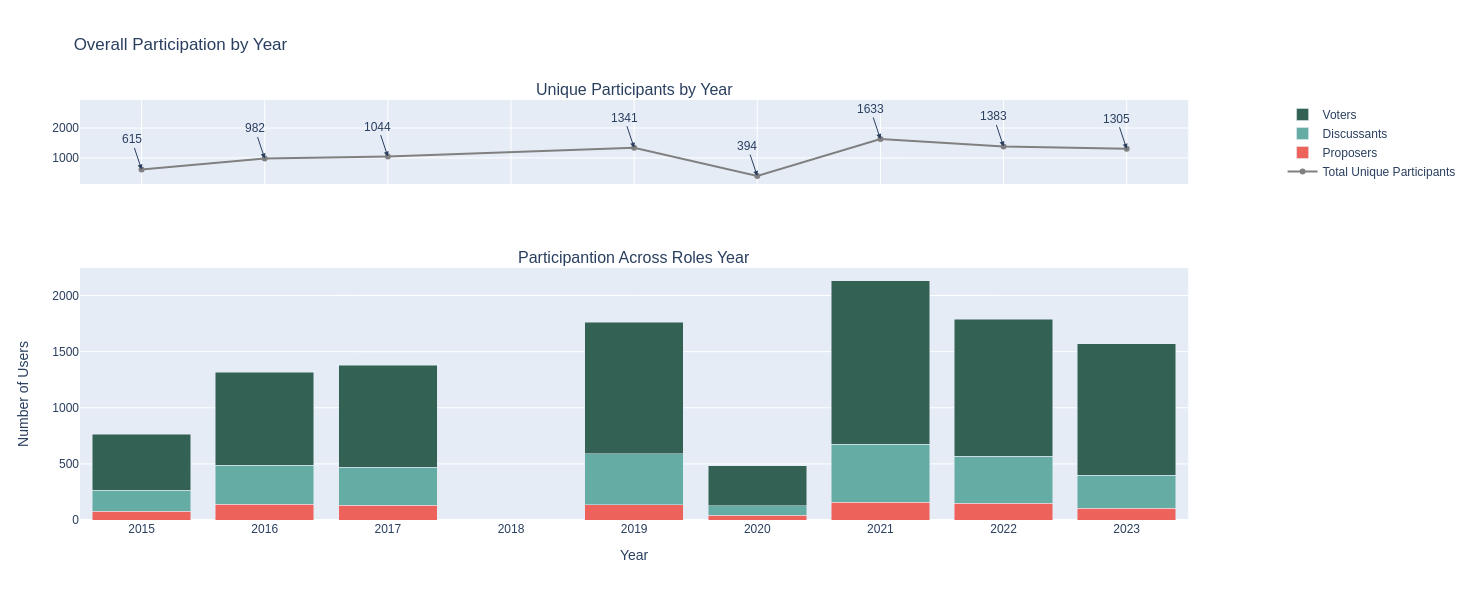

In [35]:
df = roles_by_year
df_pivot = df.pivot(index='year', columns='role', values='users').reset_index()

df_pivot['total'] = df_pivot['proposer'] + df_pivot['discussant'] + df_pivot['voter']

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.2,
    subplot_titles=('Unique Participants by Year', 'Participantion Across Roles Year'),
    row_heights=[0.25, 0.75],  # Relative heights for the subplots
    specs=[[{"secondary_y": True}], [{}]]
)

# line chart with markers
fig.add_trace(
    go.Scatter(
        x=all_participants_by_year['year'],
        y=all_participants_by_year['users'],
        mode='lines+markers',
        name='Total Unique Participants',
        line=dict(width=2, color='gray')
    ),
    row=1, col=1,
    secondary_y=False
)

# bar chart
fig.add_trace(go.Bar(name='Proposers', x=df_pivot['year'], y=df_pivot['proposer'], marker_color='#ed635c'), row=2, col=1)
fig.add_trace(go.Bar(name='Discussants', x=df_pivot['year'], y=df_pivot['discussant'], marker_color='#65aca4'), row=2, col=1)
fig.add_trace(go.Bar(name='Voters', x=df_pivot['year'], y=df_pivot['voter'], marker_color='#336154'), row=2, col=1)

# annontations
for year, participants in zip(all_participants_by_year['year'], all_participants_by_year['users']):
    fig.add_annotation(
        x=year,
        y=participants,
        text=str(participants),
        showarrow=True,
        arrowhead=2,
        yref='y1'
    )

fig.update_layout(
    barmode='stack',
    title_text='Overall Participation by Year',
    height=600,
    width=1400
)

fig.update_xaxes(title_text="Year", row=2, col=1)
fig.update_yaxes(title_text="Number of Users", row=2, col=1)

iplot(fig, config=iplot_config)

In [ ]:
fig.write_image('charts/CWS_overall_participation_by_year.svg')

#### Top categories for each role, by year

##### Top categories for proposers, by year

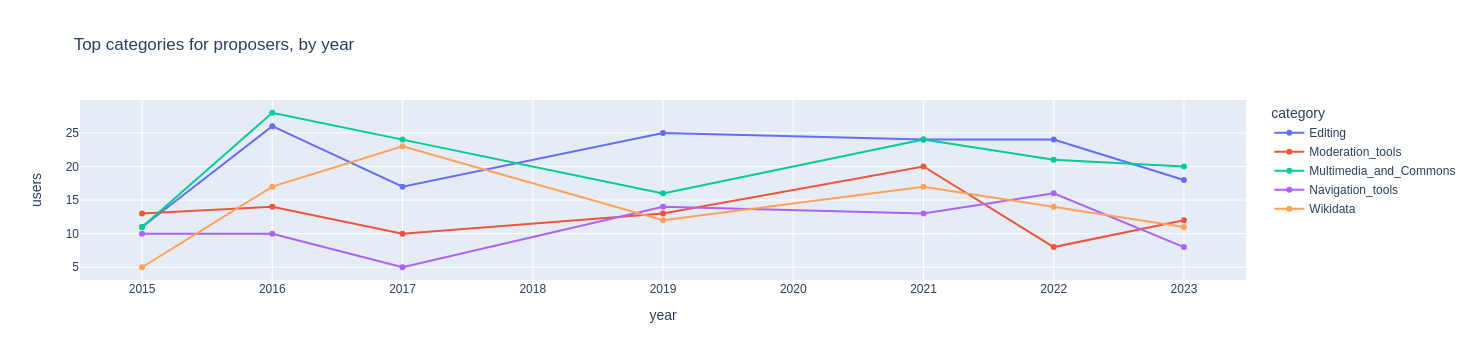

In [48]:
topp_categories = proposers_by_category.query("""proposer_rank <= 5""").category.values.tolist()
proposers_cy = roles_by_cy.query("""(category ==  @topp_categories) & (role == 'proposer')""")

fig = px.line(
    proposers_cy, 
    x='year', 
    y='users', 
    color='category', 
    markers=True, 
    width=iplot_width, 
    title='Top categories for proposers, by year'
)

iplot(fig, config=iplot_config)

##### Top categories for discussants, by year

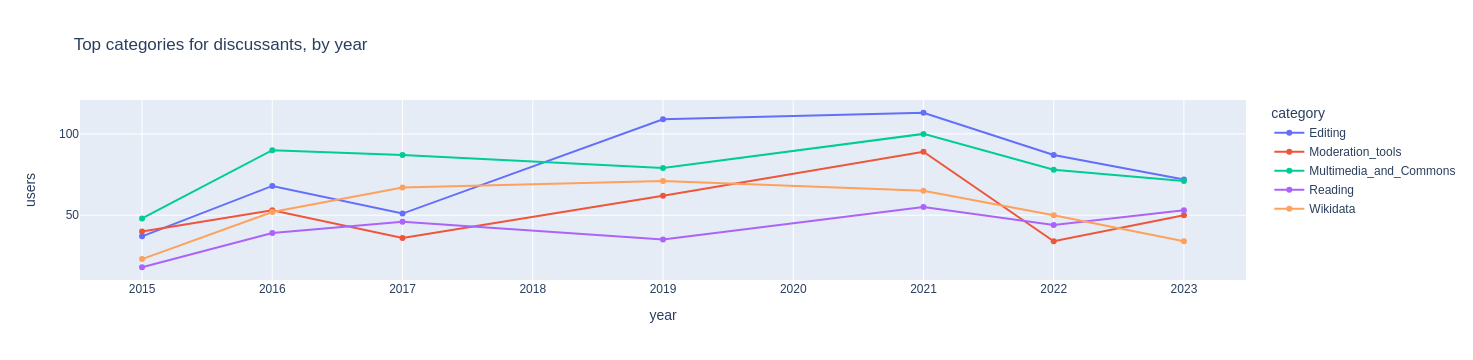

In [38]:
topd_categories = discussants_by_category.query("""discussant_rank <= 5""").category.values.tolist()
discussants_cy = roles_by_cy.query("""(category ==  @topd_categories) & (role == 'discussant')""")

fig = px.line(
    discussants_cy, 
    x='year', 
    y='users', 
    color='category', 
    markers=True, 
    width=iplot_width, 
    title='Top categories for discussants, by year')

iplot(fig, config=iplot_config)

##### Top categories for voters, by year

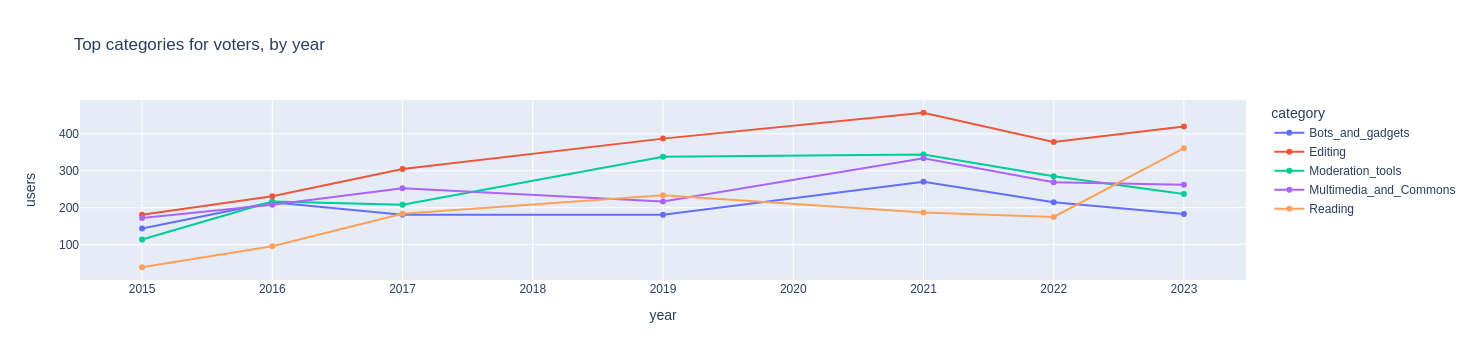

In [40]:
topv_categories = voters_by_category.query("""voter_rank <= 5""").category.values.tolist()
voters_cy = roles_by_cy.query("""(category ==  @topv_categories) & (role == 'voter')""")

fig = px.line(
    voters_cy, 
    x='year', 
    y='users', 
    color='category', 
    markers=True, 
    width=iplot_width, 
    title='Top categories for voters, by year')

iplot(fig, config=iplot_config)

### Home-wiki of participants

#### Overall

In [54]:
conn.sql("""
CREATE OR REPLACE VIEW hw_spread AS
SELECT
    *,
    ROUND(users / SUM(users) OVER (PARTITION BY year, role) * 100, 2) AS perc,
    ROW_NUMBER() OVER (PARTITION BY year, role ORDER BY users DESC) AS rank
FROM
    (       SELECT
            year,
            role,
            home_wiki,
            COUNT(DISTINCT username) AS users
        FROM
            ud_merge
        GROUP BY
            year,
            home_wiki,
            role)
""")

In [55]:
overall_hw_spread = query("""
WITH
    base AS (
    SELECT
        role,
        home_wiki,
        COUNT(DISTINCT username) AS users
    FROM
        ud_merge
    GROUP BY
        home_wiki,
        role
    )
        
SELECT
    *,
    ROUND(users / SUM(users) OVER (PARTITION BY role) * 100, 2) AS perc,
    ROW_NUMBER() OVER (PARTITION BY role ORDER BY users DESC) AS rank,
FROM
    base
            
""", True)

In [56]:
overall_hw_spread_by_year = query("""
WITH
    base AS (
    SELECT
            year,
            role,
            home_wiki,
            COUNT(DISTINCT username) AS users
        FROM
            ud_merge
        GROUP BY
            home_wiki,
            year,
            role
        )
        
SELECT
    *,
    ROUND(users / SUM(users) OVER (PARTITION BY year,role) * 100, 2) AS perc,
    ROW_NUMBER() OVER (PARTITION BY year,role ORDER BY users DESC) AS rank,
FROM
    base
            
""", True)

In [56]:
display_dfs_parallel({
    f'{role}s': perc_cumsum(overall_hw_spread.query(f"""role == '{role}'"""), 'users').head(10).drop(['role', 'rank'], axis=1).set_index('home_wiki') for role in roles
}, title='Home-wiki by various roles', bold_title=True, df_title_font_size=16)

,users,perc,percent,perc_csum
home_wiki,,,,
enwiki,215,29.82,29.82,29.82
commonswiki,115,15.95,15.95,45.77
wikidatawiki,49,6.80,6.80,52.57
dewiki,41,5.69,5.69,58.26
frwiki,26,3.61,3.61,61.87
metawiki,19,2.64,2.64,64.51
eswiki,18,2.50,2.50,67.01
ruwiki,17,2.36,2.36,69.37
zhwiki,15,2.08,2.08,71.45


In [57]:
for r in roles:
    n_wikis = overall_hw_spread[overall_hw_spread['role'] == r].home_wiki.nunique()
    print(f'unique wikis, {r}s: {n_wikis}')

unique wikis, proposers: 86
unique wikis, discussants: 126
unique wikis, voters: 227


#### Home-wiki (db group)

In [63]:
hw_db_spread = query("""
WITH
    base AS (
    SELECT
            role,
            hw_db_group,
            COUNT(DISTINCT username) AS users
        FROM
            ud_merge
        GROUP BY
            hw_db_group,
            role
        )
        
SELECT
    *,
    ROUND(users / SUM(users) OVER (PARTITION BY role) * 100, 2) AS perc,
    ROW_NUMBER() OVER (PARTITION BY role ORDER BY users DESC) AS rank,
FROM
    base
            
""", True)

In [60]:
display_dfs_parallel({
    f'{role}s': perc_cumsum(hw_db_spread.query(f"""role == '{role}'"""), 'users').head(5).drop(['role', 'rank'], axis=1).set_index('hw_db_group') for role in roles
}, title='Home-wiki by database group (for various roles)', bold_title=True, df_title_font_size=16)

,users,perc,percent,perc_csum
hw_db_group,,,,
wikipedia,453,63.00,63.00,63.00
commons,115,15.99,15.99,78.99
wikidata,49,6.82,6.82,85.81
wikisource,28,3.89,3.89,89.70
wiktionary,23,3.20,3.20,92.90
,users,perc,percent,perc_csum
hw_db_group,,,,
wikipedia,1133,60.01,60.01,60.01
commons,310,16.42,16.42,76.43


#### DB groups by year (line graphs)

In [62]:
hw_db_spread_yearly = query("""
WITH
    base AS (
    SELECT
            year,
            hw_db_group AS db_group,
            COUNT(DISTINCT username) AS users
        FROM
            ud_merge
        GROUP BY
            hw_db_group,
            year
        )
        
SELECT
    *,
    ROUND(users / SUM(users) OVER (PARTITION BY year) * 100, 2) AS perc,
    ROW_NUMBER() OVER (PARTITION BY year ORDER BY users DESC) AS rank,
FROM
    base
            
""", True)

db_spread_viz = (
    hw_db_spread_yearly
    .query("""db_group == ['wikipedia', 'commons', 'wikidata', 'wikisource', 'mediawiki', 'wiktionary']""")
    .sort_values('year')
)

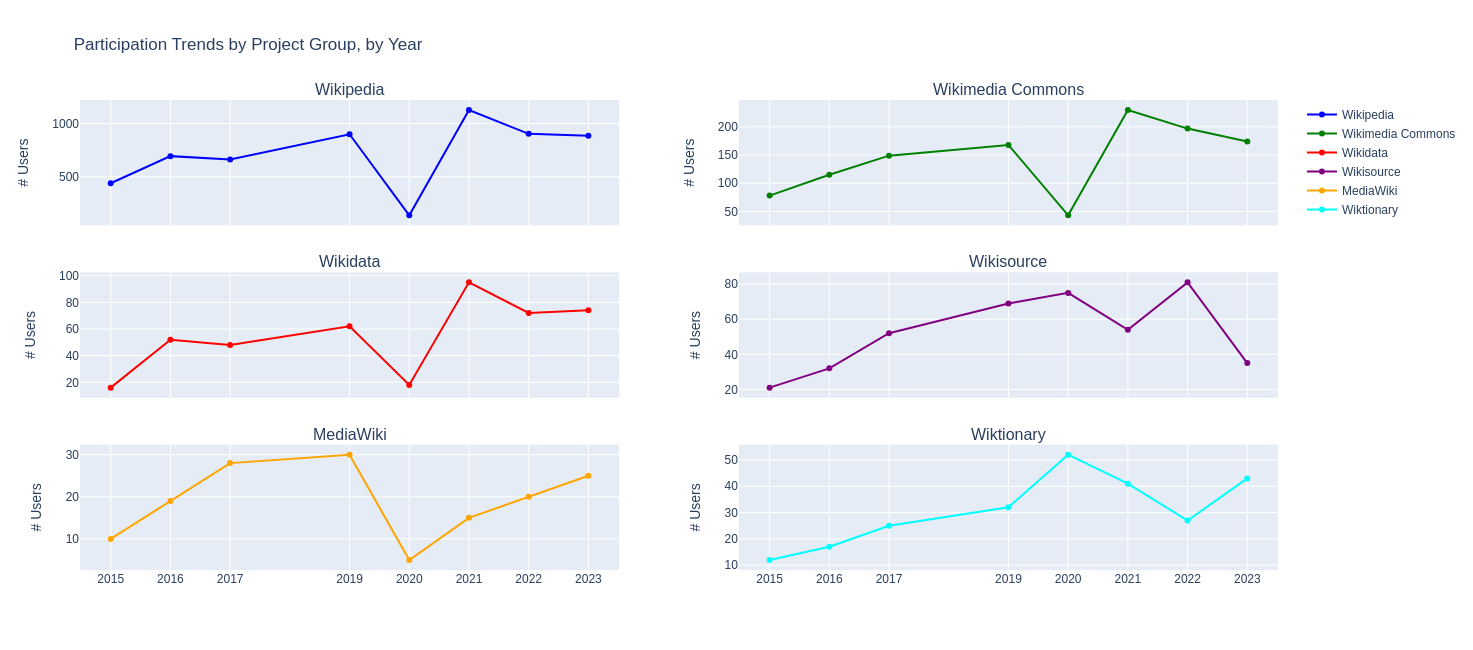

In [63]:
group_labels = {
    'wikipedia': 'Wikipedia', 
    'commons': 'Wikimedia Commons', 
    'wikidata': 'Wikidata', 
    'wikisource': 'Wikisource', 
    'mediawiki': 'MediaWiki', 
    'wiktionary': 'Wiktionary'
}

db_groups = group_labels.keys()

colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan']

fig = make_subplots(rows=3, cols=2, shared_xaxes=True, subplot_titles=[group_labels[group] for group in db_groups], vertical_spacing=0.1)

for index, group in enumerate(db_groups):
    group_data = db_spread_viz[db_spread_viz['db_group'] == group]
    fig.add_trace(
        go.Scatter(
            x=group_data['year'],
            y=group_data['users'],
            mode='lines+markers',
            name=group_labels[group],
            line=dict(color=colors[index])
        ),
        row=(index // 2) + 1,   
        col=(index % 2) + 1  
    )

fig.update_layout(height=650, width=1250, title_text="Participation Trends by Project Group, by Year")

fig.update_yaxes(title_text="# Users")
fig.update_xaxes(tickvals=db_spread_viz['year'].unique())

iplot(fig, config=iplot_config)

In [236]:
fig.write_image('charts/CWS_participation_by_db_year.svg')

#### Home-wiki (size rank)

In [65]:
hw_db_spread_size = query("""
WITH
    base AS (
    SELECT
        year,
            CASE
                WHEN size_rank <=5 THEN 'top5'
                WHEN size_rank >5 AND size_rank <=10 THEN 'top10'
                ELSE 'misc'
            END size_rank_group,
            COUNT(DISTINCT username) AS users
        FROM
            ud_merge
        GROUP BY
            size_rank_group,
            year
        )
        
SELECT
    *,
    ROUND(users / SUM(users) OVER (PARTITION BY year) * 100, 2) AS perc,
    ROW_NUMBER() OVER (PARTITION BY year ORDER BY users DESC) AS rank,
FROM
    base
            
""", True)

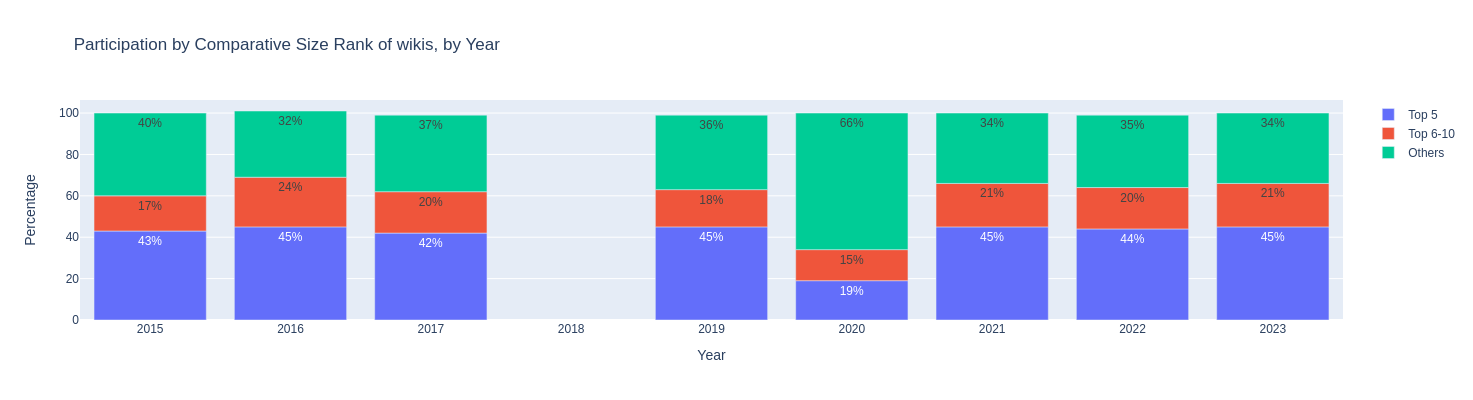

In [65]:
hw_db_spread_size['perc'] = hw_db_spread_size['perc'].round()

hw_db_spread_size['size_rank_group_display'] = hw_db_spread_size['size_rank_group'].replace({
    'top5': 'Top 5',
    'top10': 'Top 6-10',
    'misc': 'Others'
})

fig = px.bar(
    hw_db_spread_size.sort_values(['year', 'size_rank_group'], ascending=False),
    x='year', y='perc', color='size_rank_group_display',
    labels={'year': 'Year', 'perc': 'Percentage'},
    title='Participation by Comparative Size Rank of wikis, by Year'
)

fig.update_traces(texttemplate='%{y}%', textposition='inside')
fig.update_layout(legend_title_text='', height=400, width=950)

iplot(fig, config=iplot_config)

#### Participation in categories, by home-wiki

In [66]:
hw_categories_spread = query("""
WITH 
    base AS (
        SELECT 
            home_wiki,
            category,
            COUNT(DISTINCT username) AS users
        FROM ud_merge
        WHERE category <> 'Miscellaneous'
        GROUP BY
            home_wiki,
            category)

SELECT
    *,
    ROUND(users / SUM(users) OVER (PARTITION BY home_wiki) * 100, 2) AS perc,
    ROW_NUMBER() OVER (PARTITION BY home_wiki ORDER BY users DESC) AS rank
FROM
    base
""", True)

In [76]:
top_wikis = overall_hw_spread.query("""rank < 10""").home_wiki.unique().tolist()
display_dfs_parallel({
    'Top categories of participation by wiki': (
        hw_categories_spread
        .query("""(rank <= 1) & (home_wiki == @top_wikis)""")
        .sort_values('home_wiki')
        .set_index('home_wiki')
    )},
    df_title_bold=True
)

,category,users,perc,rank
home_wiki,,,,
commonswiki,Multimedia_and_Commons,413,18.46,1
dewiki,Editing,188,18.52,1
enwiki,Editing,742,14.04,1
eswiki,Editing,53,13.32,1
frwiki,Editing,78,11.89,1
mediawikiwiki,Editing,41,12.39,1
metawiki,Multimedia_and_Commons,63,9.74,1
ruwiki,Editing,45,14.24,1
wikidatawiki,Wikidata,200,22.10,1


##### by role

In [ ]:
hw_role_categories_spread = query("""
WITH 
    base AS (
        SELECT 
            home_wiki,
            role,
            category,
            COUNT(DISTINCT username) AS users
        FROM ud_merge
        WHERE category <> 'Miscellaneous'
        GROUP BY
            home_wiki,
            role,
            category)

SELECT
    *,
    ROUND(users / SUM(users) OVER (PARTITION BY role, home_wiki) * 100, 2) AS perc,
    ROW_NUMBER() OVER (PARTITION BY role, home_wiki ORDER BY users DESC) AS rank
FROM
    base
""", True)

In [81]:
display_dfs_parallel(
    {
        f'{role}s': (
            hw_role_categories_spread
            .query(f"""(rank <= 1) & (home_wiki == @top_wikis) & (role == '{role}')""")
            .sort_values('home_wiki')
            .set_index('home_wiki')
            .drop(['role', 'rank'], axis=1)
        ) for role in roles
    },
    title=f'Top categories of participation, by role and home-wiki', 
    bold_title=True
)

,category,users,perc
home_wiki,,,
commonswiki,Multimedia_and_Commons,56,36.36
dewiki,Editing,10,19.61
enwiki,Editing,57,18.81
eswiki,Navigation_tools,4,20.00
frwiki,Editing,5,16.13
mediawikiwiki,Moderation_tools,2,20.00
metawiki,Moderation_tools,4,15.38
ruwiki,Mobile_and_apps,3,18.75
wikidatawiki,Wikidata,24,36.92


#### Home-wiki db group and categories

In [79]:
db_group_role_categories_spread = query("""
WITH 
    base AS (
        SELECT 
            hw_db_group AS db_group,
            role,
            category,
            COUNT(DISTINCT username) AS users
        FROM ud_merge
        WHERE category <> 'Miscellaneous'
        GROUP BY
            category,
            role,
            hw_db_group)

SELECT
    *,
    ROUND(users / SUM(users) OVER (PARTITION BY role, db_group) * 100, 2) AS perc,
    ROW_NUMBER() OVER (PARTITION BY role, db_group ORDER BY users DESC) AS rank
FROM
    base
""", True)

## Edit bucket on home-wiki

#### Overall

In [82]:
edit_bucket_overall = query("""
SELECT
    edit_bucket.hw AS hw_edit_bucket,
    COUNT(DISTINCT username) AS users
FROM
    ud_merge
GROUP BY
    edit_bucket.hw
""", True)

display_dfs_parallel({'Edit Bucket Distribution Overall (on home-wiki)': perc_cumsum(edit_bucket_overall.sort_values('hw_edit_bucket'), 'users')}, df_title_bold=True) 

,hw_edit_bucket,users,percent,perc_csum
3,0-99,219,3.61,3.61
1,100-999,1104,18.20,21.81
2,1000-4999,1292,21.30,43.11
0,5000+,3450,56.88,99.99


In [83]:
edit_bucket_yearly = query("""
SELECT
    edit_bucket.hw AS hw_edit_bucket,
    year,
    COUNT(DISTINCT username) AS users
FROM
    ud_merge
GROUP BY
    edit_bucket.hw,
    year
ORDER BY 
    year
""", True)

display_dfs_parallel({'Distribution of edit bucket by year': edit_bucket_yearly.pivot(index='year', columns='hw_edit_bucket', values='users')}, df_title_bold=True)

hw_edit_bucket,0-99,100-999,1000-4999,5000+
year,,,,
2015,9,31,81,494
2016,27,45,175,735
2017,19,68,198,759
2019,26,129,226,960
2020,18,29,58,289
2021,53,326,274,980
2022,34,265,239,845
2023,38,289,241,737


#### Edit bucket by year (column graph)

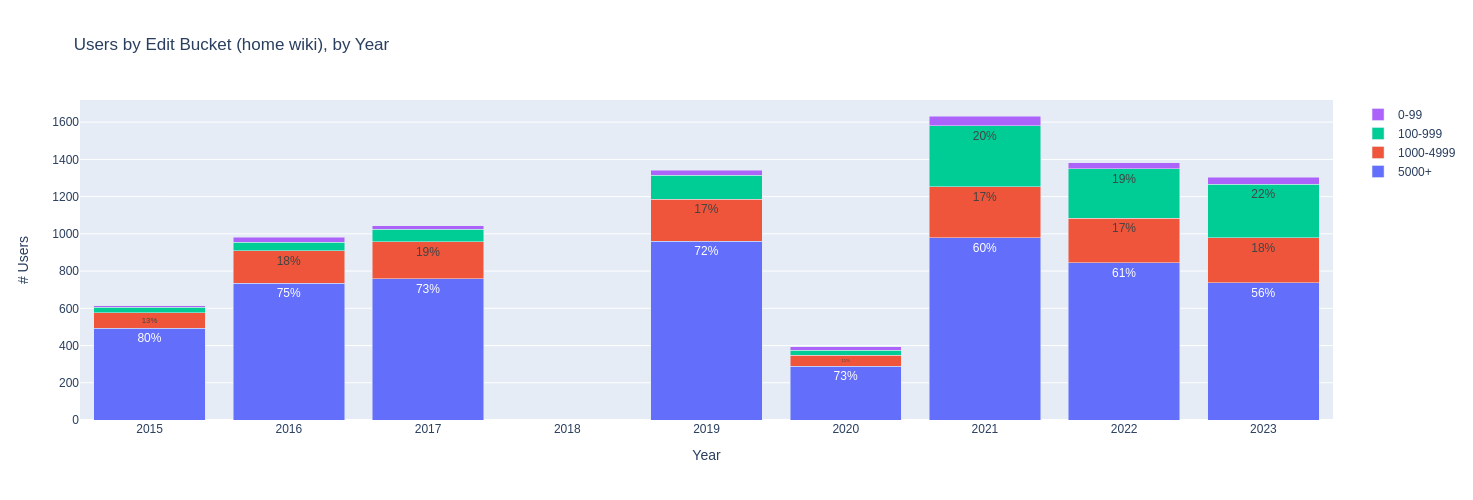

In [83]:
total_users_per_year = edit_bucket_yearly.groupby('year')['users'].sum()

df_pivot = edit_bucket_yearly.pivot(index='year', columns='hw_edit_bucket', values='users').reset_index()

fig = go.Figure()

for edit_bucket in [_ for _ in df_pivot.columns[::-1] if _ != 'year']:
    percentages = (df_pivot[edit_bucket] / df_pivot['year'].map(total_users_per_year)) * 100
    
    text_labels = []
    for year, perc in zip(df_pivot['year'], percentages):
        if edit_bucket in ["5000+", "1000-4999"] or (edit_bucket == "100-999" and year >= 2021):
            text_labels.append(f"{round(perc)}%")
        else:
            text_labels.append('')
    
    fig.add_trace(
        go.Bar(
            x=df_pivot['year'],
            y=df_pivot[edit_bucket],
            name=edit_bucket,
            text=text_labels,
            textposition='auto'
        )
    )

fig.update_layout(barmode='stack', title="Users by Edit Bucket (home wiki), by Year", height=500, width=1200)
fig.update_yaxes(title_text="# Users")
fig.update_xaxes(title_text='Year')

iplot(fig, config=iplot_config)

In [259]:
save_fig(fig, 'CWS_users_by_edits_year.svg')

#### Edit bucket by role

In [84]:
edit_bucket_by_role = query("""
SELECT
    edit_bucket.hw AS hw_edit_bucket,
    role,
    COUNT(DISTINCT username) AS users,
    ROUND(COUNT(DISTINCT username) / SUM(users) OVER (PARTITION BY role) * 100, 2) AS percent
FROM
    ud_merge
GROUP BY
    edit_bucket.hw,
    role
ORDER BY 
    role, 
    hw_edit_bucket
""", True)

display_dfs_parallel({'Edit bucket by role': edit_bucket_by_role}, df_title_bold=True)

,hw_edit_bucket,role,users,percent
0,0-99,discussant,52,2.85
1,100-999,discussant,191,10.47
2,1000-4999,discussant,325,17.82
3,5000+,discussant,1256,68.86
4,0-99,proposer,11,1.57
5,100-999,proposer,31,4.43
6,1000-4999,proposer,115,16.43
7,5000+,proposer,543,77.57
8,0-99,voter,183,3.34
9,100-999,voter,1000,18.23


#### Edit bucket by role & year

In [85]:
edit_bucket_by_role_year = query("""
SELECT
    edit_bucket.hw AS hw_edit_bucket,
    year,
    role,
    COUNT(DISTINCT username) AS users,
    ROUND(COUNT(DISTINCT username) / SUM(users) OVER (PARTITION BY role, year), 2) AS percent
FROM
    ud_merge
GROUP BY
    edit_bucket.hw,
    year,
    role
ORDER BY 
    year, 
    role, 
    hw_edit_bucket
""", True)

##### Edit bucket by role & year (heatmaps)

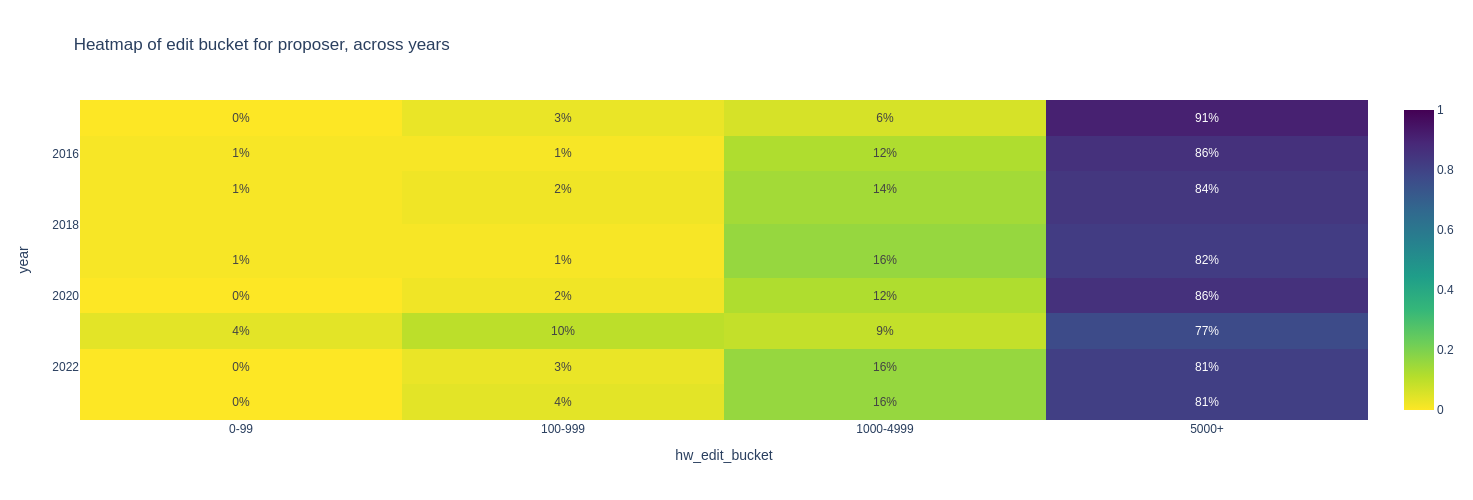

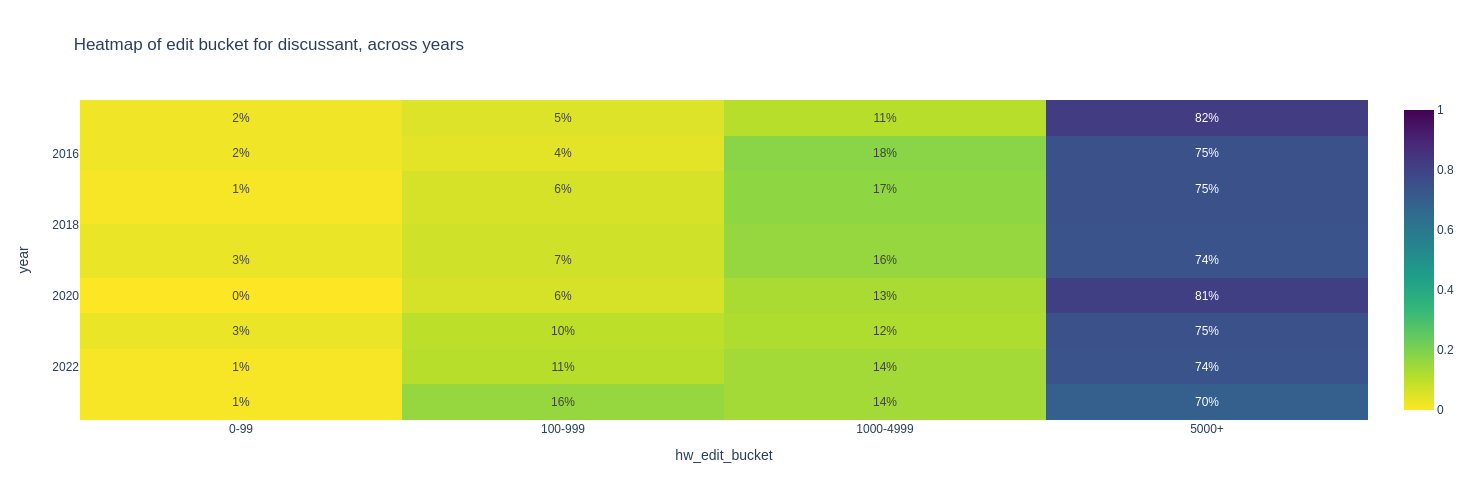

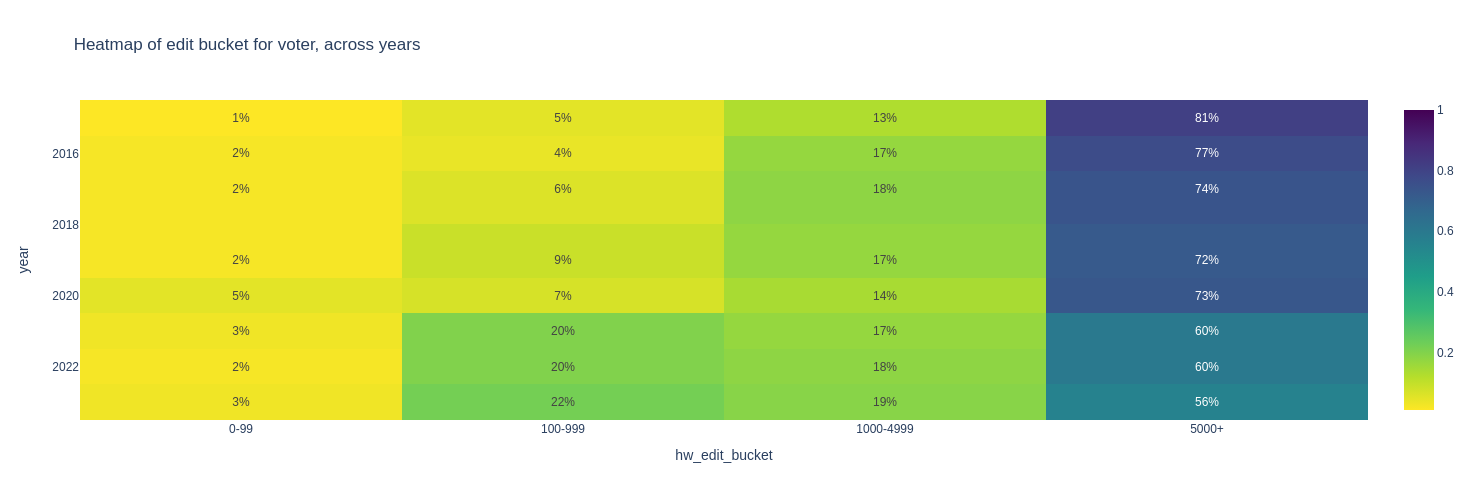

In [89]:
for role in roles:

    df_role = (
        edit_bucket_by_role_year
        .query(f"role == '{role}'")
        .pivot(index='year', columns='hw_edit_bucket', values='percent')
        .fillna(0)
    )

    fig = px.imshow(
        df_role, 
        color_continuous_scale='Viridis_r',
        width=750, 
        height=500,
        text_auto='.0%',
        zmax=1,
        title=f'Heatmap of edit bucket for {role}, across years'
    )

    iplot(fig, config=iplot_config)

#### Edit bucket by role & year (column grephs)

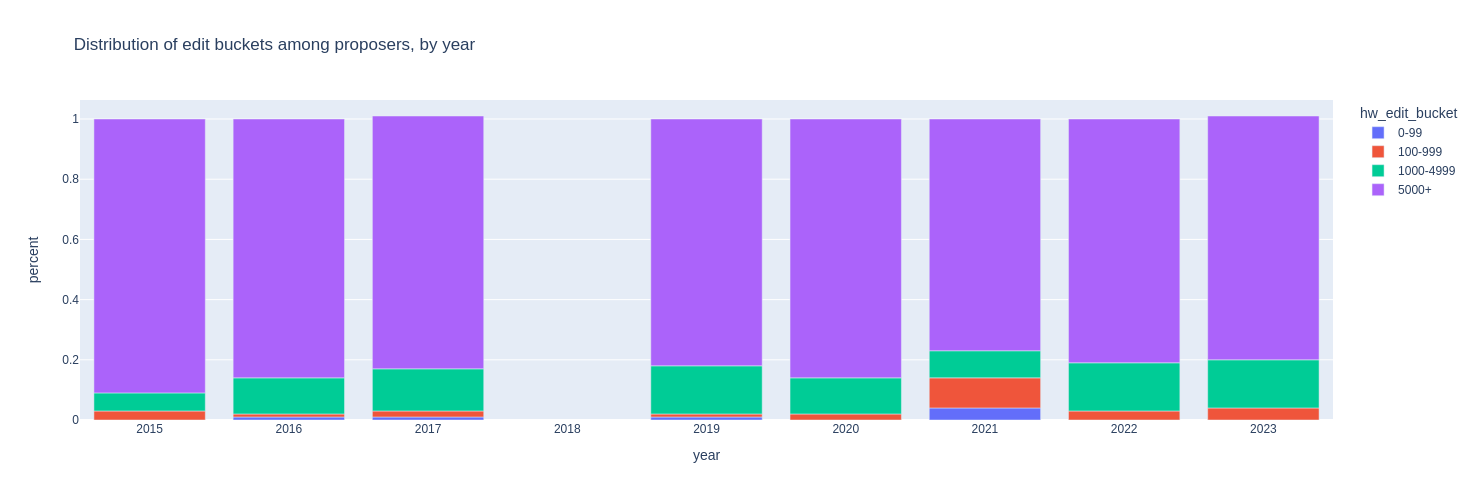

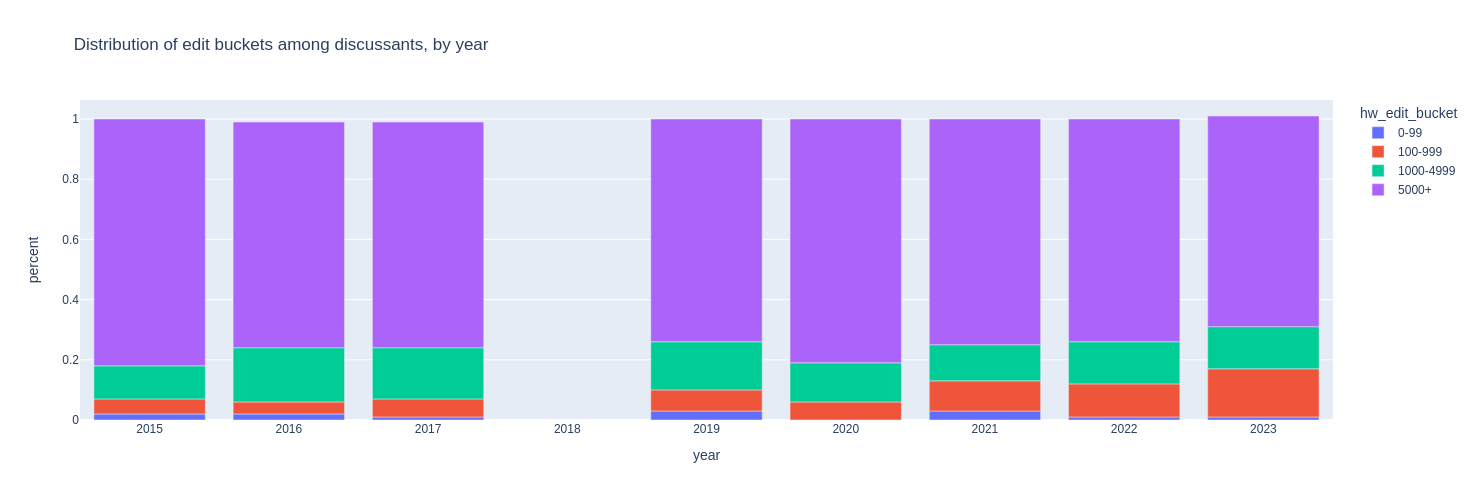

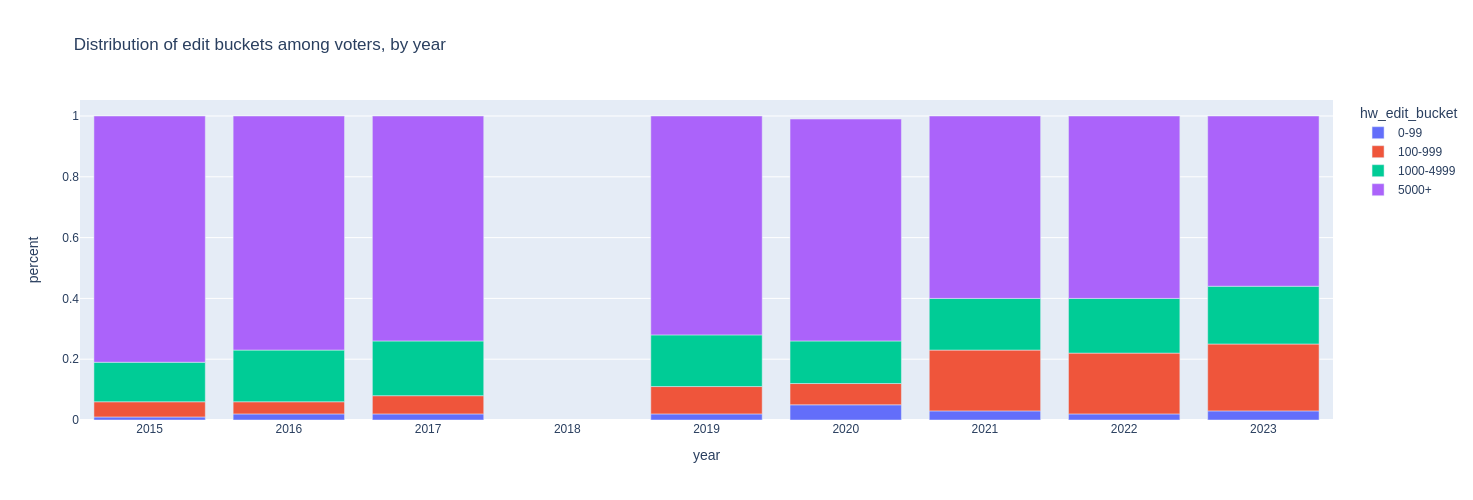

In [107]:
for role in roles:
    fig = px.bar(
        edit_bucket_by_role_year.query(f"""role == '{role}'"""), 
        x='year', 
        y='percent', 
        color='hw_edit_bucket', 
        category_orders={"hw_edit_bucket": edit_bucket_by_role_year.hw_edit_bucket.unique()},
        width=iplot_width, 
        height=500, 
        title=f'Distribution of edit buckets among {role}s, by year'
    )
    
    iplot(fig, config=iplot_config)

#### Edit buckets and categories

In [88]:
eb_role_categories_spread = query("""
WITH 
    base AS (
        SELECT 
            edit_bucket.hw AS hw_bucket,
            role,
            category,
            COUNT(DISTINCT username) AS users
        FROM ud_merge
        WHERE category <> 'Miscellaneous'
        GROUP BY
            edit_bucket.hw,
            role,
            category)

SELECT
    *,
    ROUND(users / SUM(users) OVER (PARTITION BY role, hw_bucket) * 100, 2) AS perc,
    ROW_NUMBER() OVER (PARTITION BY role, hw_bucket ORDER BY users DESC) AS rank
FROM
    base
""", True)

In [89]:
edit_buckets = ['0-99', '100-999', '1000-4999', '5000+']

display_dfs_parallel(
    {
        f'{role}s': (
            eb_role_categories_spread
            .query(f"""(rank <= 3) & (role == '{role}')""")
            .assign(hw_bucket=lambda df: pd.Categorical(df['hw_bucket'], categories=edit_buckets, ordered=True))
            .sort_values('hw_bucket')
            .drop(['role', 'rank'], axis=1)
            .set_index(['hw_bucket', 'category'], verify_integrity=True)
        )
        for role in roles
    },
    title='Top three categories of participation among proposers, by edit bucket', 
    bold_title=True
)

proposers 

 
 
 
 
 
 users 
 perc 
 
 
 hw_bucket 
 category 
 
 
 
 
 
 
 0-99 
 Reading 
 4 
 36.36 
 
 
 Communication_tools 
 1 
 9.09 
 
 
 Moderation_tools 
 1 
 9.09 
 
 
 100-999 
 Editing 
 10 
 30.30 
 
 
 Reading 
 5 
 15.15 
 
 
 Multimedia_and_Commons 
 3 
 9.09 
 
 
 1000-4999 
 Editing 
 21 
 16.15 
 
 
 Multimedia_and_Commons 
 18 
 13.85 
 
 
 Mobile_and_apps 
 12 
 9.23 
 
 
 5000+ 
 Multimedia_and_Commons 
 105 
 13.76 
 
 
 Editing 
 98 
 12.84 
 
 
 Wikidata 
 71 
 9.31 
 
 
 
 discussants 

 
 
 
 
 
 users 
 perc 
 
 
 hw_bucket 
 category 
 
 
 
 
 
 
 0-99 
 Reading 
 11 
 16.92 
 
 
 Multimedia_and_Commons 
 10 
 15.38 
 
 
 Editing 
 6 
 9.23 
 
 
 100-999 
 Editing 
 48 
 15.48 
 
 
 Reading 
 44 
 14.19 
 
 
 Multimedia_and_Commons 
 40 
 12.90 
 
 
 1000-4999 
 Multimedia_and_Commons 
 85 
 15.57 
 
 
 Editing 
 72 
 13.19 
 
 
 Reading 
 46 
 8.42 
 
 
 5000+ 
 Editing 
 294 
 11.85 
 
 
 Multimedia_and_Commons 
 291 
 11.73 
 
 
 Moderation_tools 
 224 
 9.03 
 
 
 
 voters 

 
 
 
 
 
 users 
 perc 
 
 
 hw_bucket 
 category 
 
 
 
 
 
 
 0-99 
 Reading 
 43 
 15.81 
 
 
 Wikisource 
 40 
 14.71 
 
 
 Multimedia_and_Commons 
 32 
 11.76 
 
 
 100-999 
 Editing 
 290 
 14.99 
 
 
 Reading 
 174 
 8.99 
 
 
 Moderation_tools 
 152 
 7.86 
 
 
 1000-4999 
 Editing 
 384 
 14.00 
 
 
 Multimedia_and_Commons 
 231 
 8.42 
 
 
 Reading 
 219 
 7.99 
 
 
 5000+ 
 Editing 
 1150 
 11.42 
 
 
 Moderation_tools 
 942 
 9.35 
 
 
 Multimedia_and_Commons 
 856 
 8.50

### Edit bucket on Meta Wiki

#### Overall

In [122]:
mw_edit_bucket_overall = query("""
SELECT
    edit_bucket.mw AS mw_edit_bucket,
    COUNT(DISTINCT username) AS users
FROM
            ud_merge
        GROUP BY
edit_bucket.mw
ORDER BY mw_edit_bucket
""", True)

total_users_per_year = mw_edit_bucket_yearly.groupby('year')['users'].sum()
mw_edit_bucket_overall = perc_cumsum(mw_edit_bucket_overall, 'users')

mw_edit_bucket_yearly = query("""
SELECT
    edit_bucket.mw AS mw_edit_bucket,
    year,
    COUNT(DISTINCT username) AS users
FROM
    ud_merge
GROUP BY
    edit_bucket.mw,
    year
ORDER BY 
    year
""", True)


display_dfs_parallel({
    'Edit bucket on Meta-Wiki': mw_edit_bucket_overall.set_index('mw_edit_bucket'),
    'Edit bucket on Meta-Wiki, by year': mw_edit_bucket_yearly.pivot(index='year', columns='mw_edit_bucket', values='users').reset_index().set_index('year')
}, df_title_bold=True)

Edit bucket on Meta-Wiki 

 
 
 
 
 users 
 percent 
 perc_csum 
 
 
 mw_edit_bucket 
 
 
 
 
 
 
 
 0-99 
 4317 
 69.25 
 69.25 
 
 
 100-999 
 1183 
 18.98 
 88.23 
 
 
 1000-4999 
 391 
 6.27 
 94.50 
 
 
 5000+ 
 343 
 5.50 
 100.00 
 
 
 
 Edit bucket on Meta-Wiki, by year 

 
 
 
 mw_edit_bucket 
 0-99 
 100-999 
 1000-4999 
 5000+ 
 
 
 year 
 
 
 
 
 
 
 
 
 2015 
 362 
 167 
 50 
 36 
 
 
 2016 
 586 
 261 
 90 
 45 
 
 
 2017 
 588 
 296 
 104 
 56 
 
 
 2019 
 838 
 319 
 120 
 64 
 
 
 2020 
 206 
 99 
 50 
 39 
 
 
 2021 
 1062 
 331 
 137 
 103 
 
 
 2022 
 883 
 291 
 122 
 87 
 
 
 2023 
 862 
 240 
 107 
 96

#### Edit bucket on Meta-Wiki, by year (column graph)

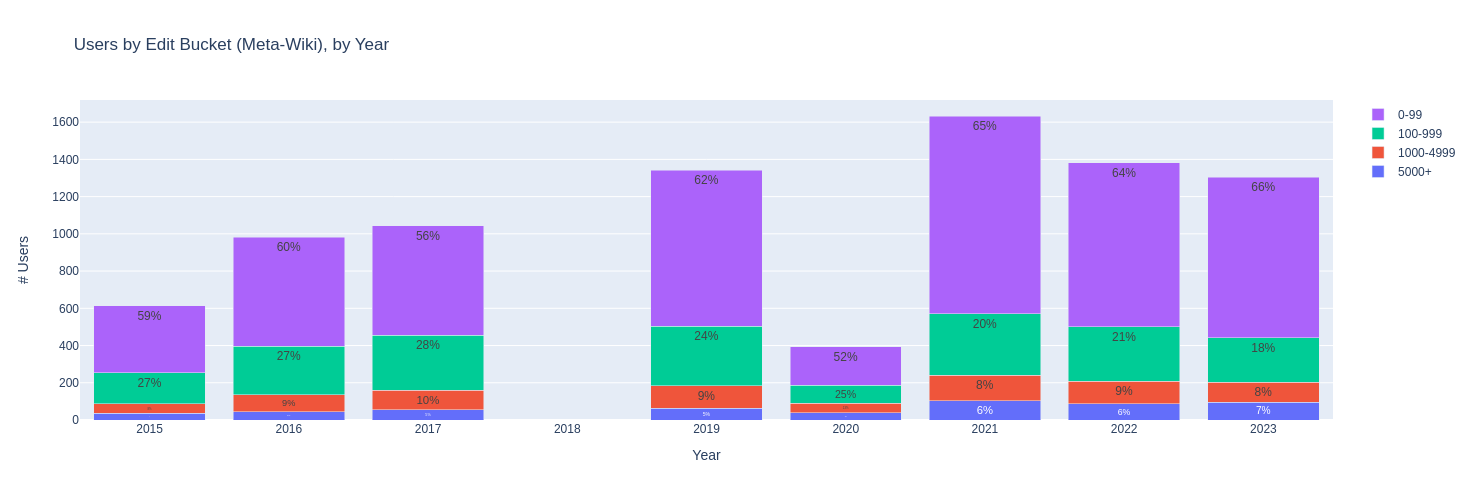

In [123]:
total_users_per_year = mw_edit_bucket_yearly.groupby('year')['users'].sum()

mw_edit_bucket_yearly_pvt = mw_edit_bucket_yearly.pivot(index='year', columns='mw_edit_bucket', values='users').reset_index()

fig = go.Figure()

for edit_bucket in [_ for _ in mw_edit_bucket_yearly_pvt.columns[::-1] if _ != 'year']:

    percentages = (mw_edit_bucket_yearly_pvt[edit_bucket] / mw_edit_bucket_yearly_pvt['year'].map(total_users_per_year)) * 100
    
    text_labels = []
    for year, perc in zip(mw_edit_bucket_yearly_pvt['year'], percentages):
        text_labels.append(f"{round(perc)}%")

    fig.add_trace(
        go.Bar(
            x=mw_edit_bucket_yearly_pvt['year'],
            y=mw_edit_bucket_yearly_pvt[edit_bucket],
            name=edit_bucket,
            text=text_labels,
            textposition='auto'
        )
    )

fig = (
    fig
    .update_layout(
        barmode='stack', 
        title="Users by Edit Bucket (Meta-Wiki), by Year", 
        height=500, 
        width=iplot_width)
    .update_yaxes(title_text="# Users")
    .update_xaxes(title_text='Year')
)

iplot(fig, config=iplot_config)

#### Meta-Wiki edit bucket by role

In [124]:
mw_edit_bucket_by_role = query("""
SELECT
    edit_bucket.mw AS mw_edit_bucket,
    role,
    COUNT(DISTINCT username) AS users,
    ROUND(COUNT(DISTINCT username) / SUM(users) OVER (PARTITION BY role) * 100, 2) AS percent
FROM
    ud_merge
GROUP BY
    edit_bucket.mw,
    role
ORDER BY 
    role, 
    mw_edit_bucket
""", True)

display_dfs_parallel({'Edit bucket on Meta-Wiki, by role': mw_edit_bucket_by_role}, df_title_bold=True) 

,mw_edit_bucket,role,users,percent
0,0-99,discussant,997,52.31
1,100-999,discussant,548,28.75
2,1000-4999,discussant,208,10.91
3,5000+,discussant,153,8.03
4,0-99,proposer,347,46.96
5,100-999,proposer,223,30.18
6,1000-4999,proposer,105,14.21
7,5000+,proposer,64,8.66
8,0-99,voter,3954,70.28
9,100-999,voter,1043,18.54


#### Meta-Wiki edit bucket by role & year

In [126]:
mw_edit_bucket_by_role_year = query("""
 SELECT
            edit_bucket.mw AS mw_edit_bucket,
            year,
            role,
            COUNT(DISTINCT username) AS users,
            ROUND(COUNT(DISTINCT username) / SUM(users) OVER (PARTITION BY role, year) * 100, 2) AS percent
        FROM
            ud_merge
        GROUP BY
edit_bucket.mw,
year,
role
ORDER BY year, role, mw_edit_bucket

""", True)

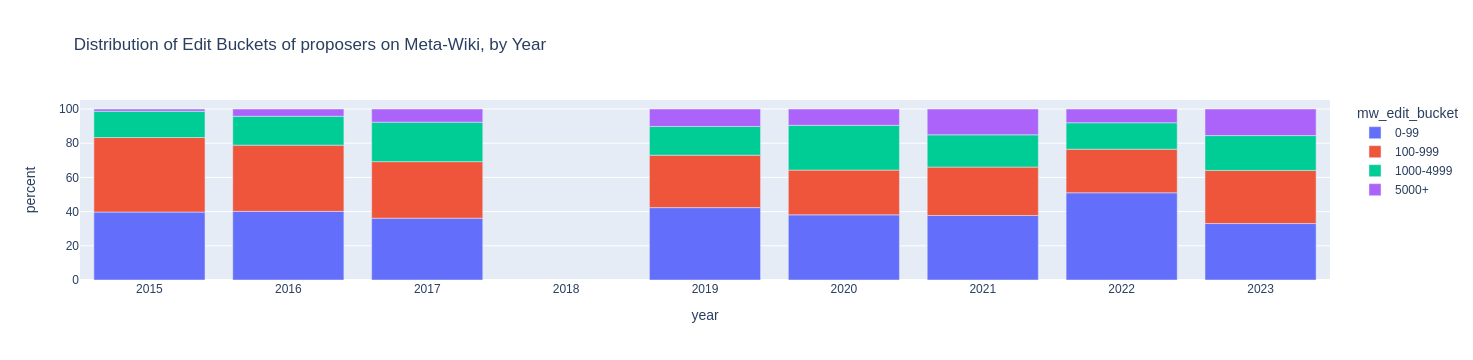

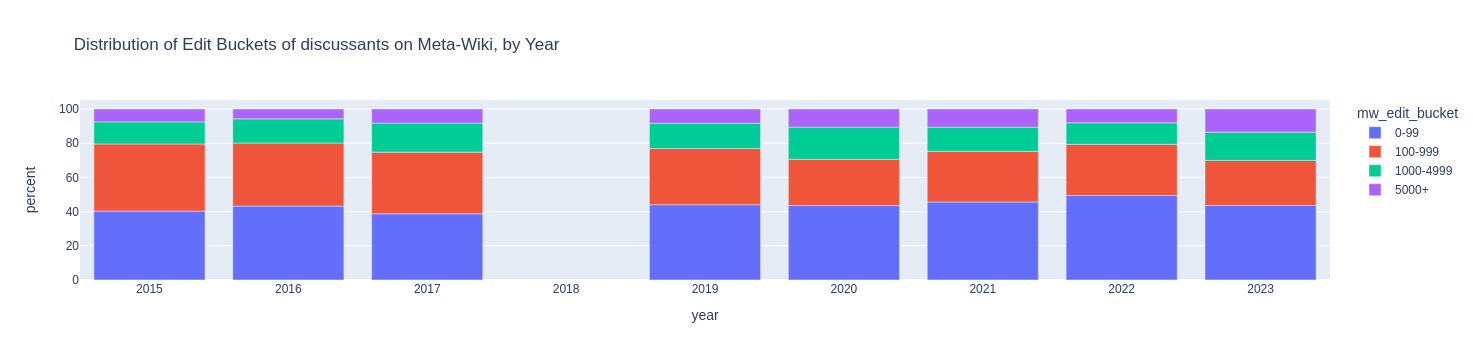

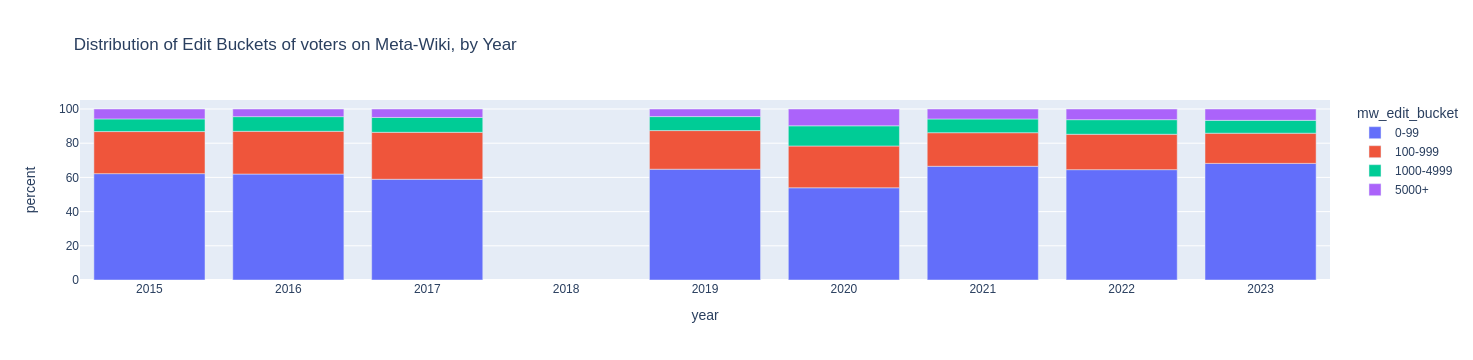

In [132]:
for role in roles:
    fig = (
        px
        .bar(
            mw_edit_bucket_by_role_year.query(f"""role == '{role}'"""), 
            x='year', 
            y='percent', 
            color='mw_edit_bucket',
            category_orders={"hw_edit_bucket": mw_edit_bucket_by_role_year.mw_edit_bucket.unique()},
            width=iplot_width, 
            title=f'Distribution of Edit Buckets of {role}s on Meta-Wiki, by Year')
    )
        
    iplot(fig, config=iplot_config)

### User rights on home-wiki

In [133]:
advanced = ['abusefilter', 'sysop', 'interface-admin', 'checkuser', 'oversight', 'botadmin']
exclude = ['extendedconfirmed', 'ipblock-exempt']

In [134]:
def categorize_rights(groups):
    if any(right in groups for right in advanced):
        return 'advanced'
    elif not groups or all(right in exclude for right in groups):
        return 'none'
    else:
        return 'intermediate'

In [135]:
ud_df = query("""SELECT * FROM ud_merge""", True)
ud_df['rights_category'] = ud_df['hw_user_groups'].apply(categorize_rights)

#### Users rights, by role

In [136]:
unique_users_by_group = ud_df.groupby(['role', 'rights_category'])['username'].nunique().reset_index(name='unique_users')
total_users_by_role = ud_df.groupby('role')['username'].nunique()
unique_users_by_group['percentage'] = unique_users_by_group.apply(lambda row: (row['unique_users'] / total_users_by_role[row['role']]) * 100, axis=1).round(2)

display_dfs_parallel({
    'Unique users by user-rights levels': unique_users_by_group.set_index(['role', 'rights_category'], verify_integrity = True)
}, df_title_bold=True)

Unique users by user-rights levels 

 
 
 
 
 
 unique_users 
 percentage 
 
 
 role 
 rights_category 
 
 
 
 
 
 
 discussant 
 advanced 
 493 
 28.35 
 
 
 intermediate 
 824 
 47.38 
 
 
 none 
 517 
 29.73 
 
 
 proposer 
 advanced 
 207 
 30.26 
 
 
 intermediate 
 334 
 48.83 
 
 
 none 
 163 
 23.83 
 
 
 voter 
 advanced 
 1070 
 20.47 
 
 
 intermediate 
 2325 
 44.48 
 
 
 none 
 2027 
 38.78

#### Users rights, by year (column graph)

In [137]:
rights_yearly = (
    ud_df[['year', 'rights_category', 'username']]
    .drop_duplicates()
    .groupby(['year', 'rights_category'])
    .agg({
        'username': 'count'
    })
    .reset_index()
)

rights_yearly_pvt = rights_yearly.pivot(index='year', columns='rights_category', values='username')

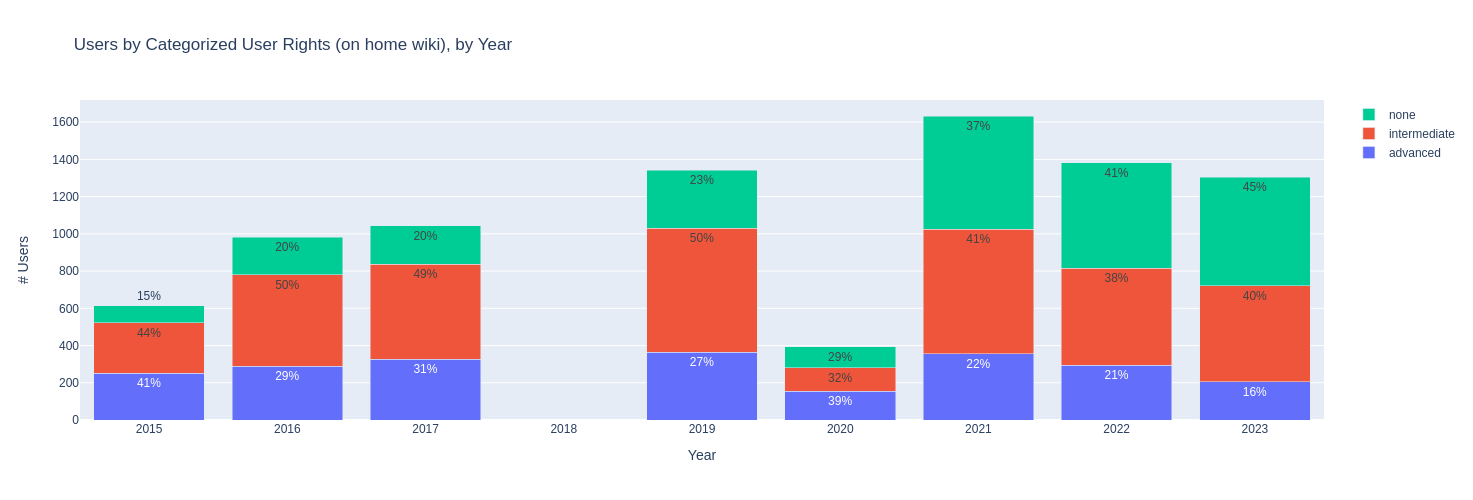

In [138]:
total_users_per_year = rights_yearly.groupby('year')['username'].sum()
rights_yearly_pvt = rights_yearly.pivot(index='year', columns='rights_category', values='username').reset_index()

fig = go.Figure()
for edit_bucket in ['advanced', 'intermediate', 'none']:
    
    percentages = (rights_yearly_pvt[edit_bucket] / rights_yearly_pvt['year'].map(total_users_per_year)) * 100
    
    text_labels = []
    for year, perc in zip(rights_yearly_pvt['year'], percentages):
            text_labels.append(f"{round(perc)}%")

    
    fig.add_trace(
        go.Bar(
            x=rights_yearly_pvt['year'],
            y=rights_yearly_pvt[edit_bucket],
            name=edit_bucket,
            text=text_labels,
            textposition='auto'
        )
    )

fig = (
    fig
    .update_layout(barmode='stack', title="Users by Categorized User Rights (on home wiki), by Year", height=500, width=iplot_width)
    .update_yaxes(title_text="# Users")
    .update_xaxes(title_text='Year')
)

iplot(fig, config=iplot_config)

In [328]:
save_fig(fig, 'CWS_user_rights_by_year')

#### User rights and categories

In [139]:
rights_role_categories_spread = query("""
WITH 
    base AS (
        SELECT 
            edit_bucket.hw AS hw_bucket,
            role,
            category,
            COUNT(DISTINCT username) AS users
        FROM ud_merge
        WHERE category <> 'Miscellaneous'
        GROUP BY
            edit_bucket.hw,
            role,
            category)

SELECT
    *,
    ROUND(users / SUM(users) OVER (PARTITION BY role, hw_bucket) * 100, 2) AS perc,
    ROW_NUMBER() OVER (PARTITION BY role, hw_bucket ORDER BY users DESC) AS rank
FROM
    base
""", True)

### Global user account age

In [140]:
avg_age_yearly = query("""SELECT year, ROUND(AVG(account_age.years)) AS avg_age FROM ud_merge GROUP BY year""", True)
display_dfs_parallel({'Average global user age, by year': avg_age_yearly}, df_title_bold=True)

,year,avg_age
0,2015,5.0
1,2016,6.0
2,2017,7.0
3,2019,7.0
4,2020,8.0
5,2021,8.0
6,2022,9.0
7,2023,9.0


#### Account age by role and year

In [141]:
avg_age_by_year_role = query("""
WITH
    base AS (
        SELECT
            DISTINCT username,
            year,
            role,
            account_age.years AS account_age
        FROM
            ud_merge) 

SELECT 
    year,
    role,
    ROUND(AVG(account_age))::INT AS avg_age,
    ROUND(MEDIAN(account_age))::INT AS median_age,
    MODE(ROUND(account_age))::INT AS mode_age
FROM 
    base 
GROUP BY
    role,
    year
ORDER BY
    year,
    role""", True)

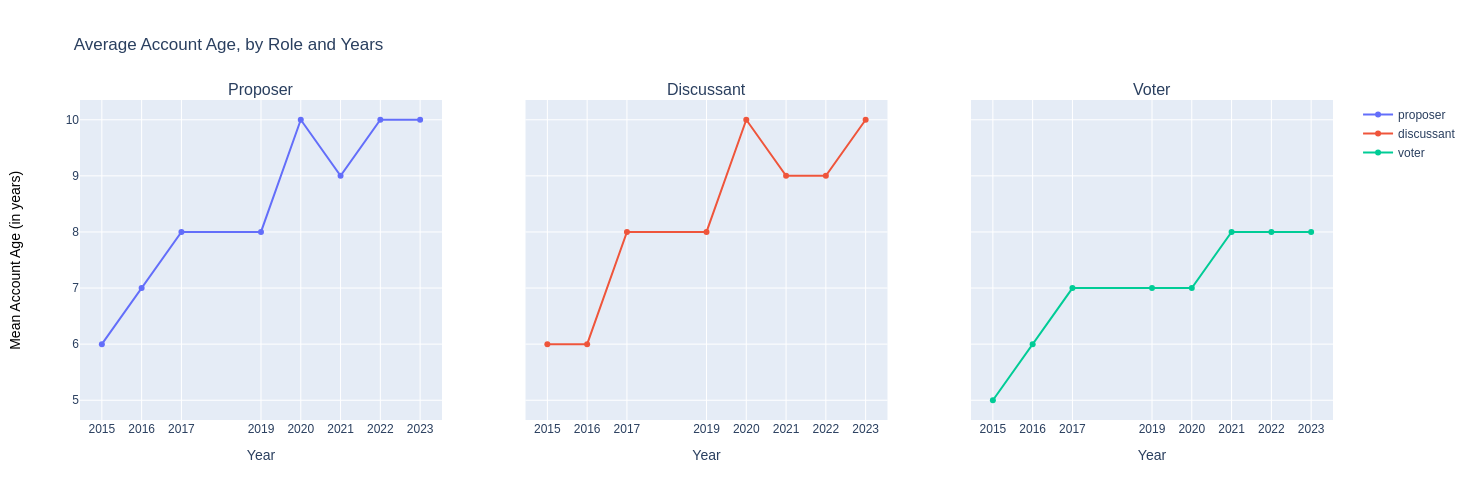

In [142]:
fig = make_subplots(rows=1, cols=3, shared_yaxes=True, subplot_titles=('Proposer', 'Discussant', 'Voter'))

for i, role in enumerate(roles):
    
    subset = avg_age_by_year_role[avg_age_by_year_role['role'] == role]
    
    fig.add_trace(go.Scatter(x=subset['year'], 
                             y=subset['median_age'],
                             mode='lines+markers',
                             name=role),
                  row=1, col=i+1)

fig = (
    fig
    .update_layout(
        title_text="Average Account Age, by Role and Years", 
        width=iplot_width+300, 
        height=500)
    .update_xaxes(
        title_text='Year', 
        tickvals=avg_age_by_year_role['year'].unique()
    )    
    .add_annotation(
        dict(
            font=dict(color="black",size=14),
            x=-0.06,
            y=0.5,
            showarrow=False,
            text="Mean Account Age (in years)",
            textangle=-90,
            xref="paper",
            yref="paper"
            )
    )
)

iplot(fig, config=iplot_config)

In [ ]:
save_fig(fig, 'CWS_account_age_by_role.svg')

#### User account age and categories

In [143]:
age_cat = query("""
WITH 
base AS (
    SELECT 
        category,
        AVG(account_age.years) AS avg_account_age,
        COUNT(DISTINCT username) AS users
    FROM 
        ud_merge
    WHERE 
        category <> 'Miscellaneous'
    GROUP BY
        category
)

SELECT
    *,
    ROUND(avg_account_age / SUM(avg_account_age) OVER (PARTITION BY category) * 100, 2) AS perc_age
FROM
    base
ORDER BY
    avg_account_age DESC
""", True)

display_dfs_parallel({'Average account age by category of participation': age_cat.drop(['users', 'perc_age'], axis = 1)}, df_title_bold=True)

,category,avg_account_age
0,Wikispecies,8.638333
1,Wiktionary,8.256021
2,Wikidata,7.994669
3,Citations,7.868053
4,Multimedia_and_Commons,7.867084
5,Wikivoyage,7.691438
6,Translation,7.646807
7,Wikibooks,7.640758
8,Navigation_tools,7.633916
9,Wikisource,7.579554


In [144]:
age_cat_role = query("""
WITH 
base AS (
    SELECT 
        category,
        role,
        AVG(account_age.years) AS avg_account_age,
        COUNT(DISTINCT username) AS users
    FROM ud_merge
    WHERE category <> 'Miscellaneous'
    GROUP BY
        category,
        role)

SELECT
    *,
    ROUND(avg_account_age / SUM(avg_account_age) OVER (PARTITION BY role, category) * 100, 2) AS perc_age,
    ROW_NUMBER() OVER (PARTITION BY role, category ORDER BY avg_account_age DESC) AS rank
FROM
    base
ORDER BY
    avg_account_age DESC
""", True)

### Newcomers

#### Overall

In [145]:
newcomer_data = query("""
SELECT 
    year, 
    username, 
    role, 
    home_wiki, 
    edit_bucket.hw AS edit_bucket, 
    hw_db_group, 
    account_age.years AS account_age, 
    category 
FROM 
    ud_merge""", True).drop_duplicates(['year', 'username', 'role'])

In [146]:
# generate a column to indicate user status: newcomer or returning participant

users_per_year = newcomer_data.groupby('year')['username'].unique().to_dict()
prev_years_users = set()

for year in sorted(newcomer_data['year'].unique()):
    mask = newcomer_data['year'] == year
    
    newcomer_data.loc[mask, 'user_status'] = newcomer_data[mask]['username'].apply(lambda user: 'returning' if user in prev_years_users else 'newcomer')
    
    prev_years_users.update(users_per_year[year])

In [149]:
# percentage of new and returning participants, by year

count_by_user_status = newcomer_data.groupby(['year', 'user_status']).agg({'username': 'count'}).reset_index()
total_users = newcomer_data.groupby('year').agg({'username': 'count'}).rename(columns={'username': 'total_users'})

count_by_user_status = count_by_user_status.merge(total_users, on='year')
count_by_user_status['percentage'] = (count_by_user_status['username'] / count_by_user_status['total_users']) * 100

display_dfs_parallel({'New and returning participants, by year': count_by_user_status}, df_title_bold=True)

,year,user_status,username,total_users,percentage
0,2015,newcomer,764,764,100.000000
1,2016,newcomer,994,1317,75.474563
2,2016,returning,323,1317,24.525437
3,2017,newcomer,816,1381,59.087618
4,2017,returning,565,1381,40.912382
5,2019,newcomer,979,1764,55.498866
6,2019,returning,785,1764,44.501134
7,2020,newcomer,213,483,44.099379
8,2020,returning,270,483,55.900621
9,2021,newcomer,1285,2133,60.243788


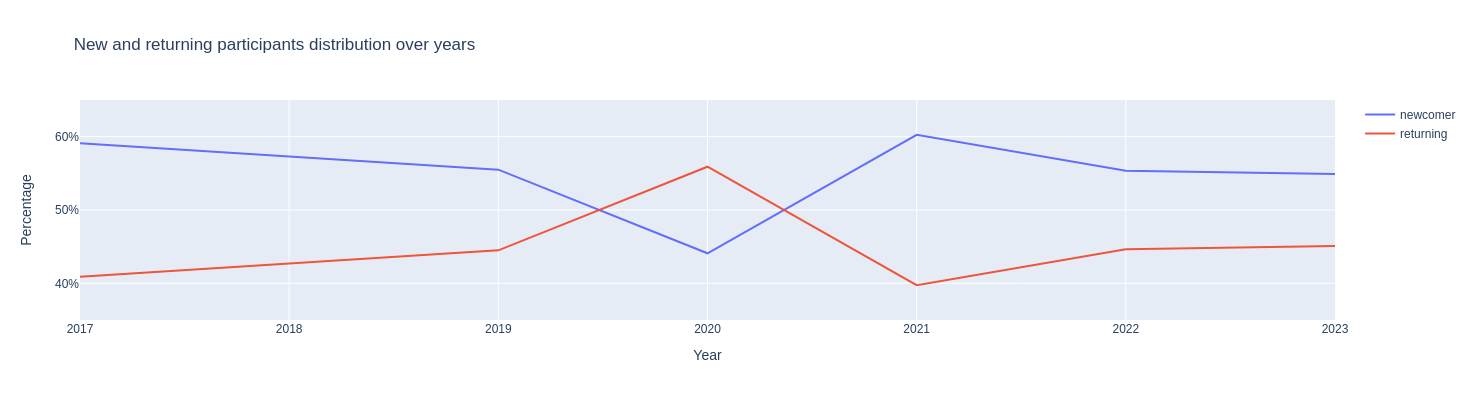

In [150]:
fig = px.line(count_by_user_status.query("year >= 2017"), x='year', y='percentage', color='user_status', 
              title="New and returning participants distribution over years",
              labels={'year': 'Year', 'percentage': 'Percentage'}, width=900, height=400)


fig = (
    fig
    .update_yaxes(range=[35, 65], tickvals=list(range(20, 90, 10)), 
                  ticktext=['20%', '30%', '40%', '50%', '60%', '70%', '80%'])
    .update_layout(legend={'title_text':''})
)

iplot(fig, config=iplot_config)

#### Newcomers by role

In [151]:
# percentage of new and returning participants, by year & role

newcomer_by_role_year = newcomer_data.groupby(['year', 'role', 'user_status']).agg({'username': 'count'}).reset_index()
total_newcomers_by_role = newcomer_data.groupby(['year', 'role']).agg({'username': 'count'}).rename(columns={'username': 'total_role_users'})

newcomer_by_role_year = newcomer_by_role_year.merge(total_newcomers_by_role, on=['year', 'role'])
newcomer_by_role_year['percentage'] = (newcomer_by_role_year['username'] / newcomer_by_role_year['total_role_users']) * 100

display_dfs_parallel({'New and returning participants, by year & role': newcomer_by_role_year}, df_title_bold=True)

,year,role,user_status,username,total_role_users,percentage
0,2015,discussant,newcomer,186,186,100.000000
1,2015,proposer,newcomer,78,78,100.000000
2,2015,voter,newcomer,500,500,100.000000
3,2016,discussant,newcomer,239,347,68.876081
4,2016,discussant,returning,108,347,31.123919
5,2016,proposer,newcomer,96,142,67.605634
6,2016,proposer,returning,46,142,32.394366
7,2016,voter,newcomer,659,828,79.589372
8,2016,voter,returning,169,828,20.410628
9,2017,discussant,newcomer,164,341,48.093842


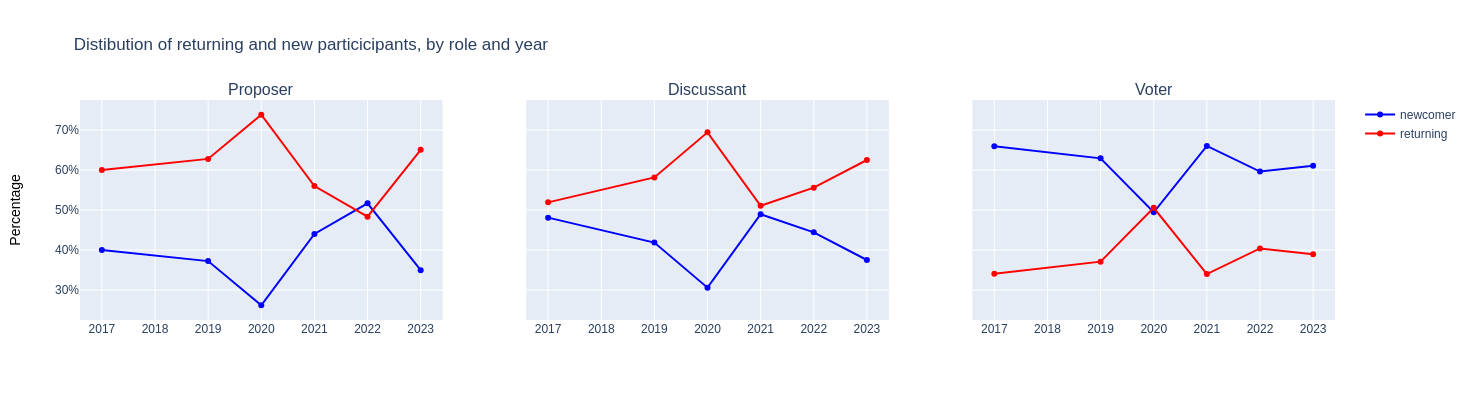

In [152]:
last_year = newcomer_by_role_year['year'].max()

fig = make_subplots(rows=1, cols=3, 
                    subplot_titles=("Proposer", "Discussant", "Voter"),
                    shared_yaxes=True)

roles = ["proposer", "discussant", "voter"]
color_map = {"newcomer": "blue", "returning": "red"}

for idx, role in enumerate(roles, 1):
    
    subset = newcomer_by_role_year.query(f"""(year >= 2017) & (role == '{role}')""")
    
    for user_status in subset['user_status'].unique():
        role_subset = subset[subset['user_status'] == user_status]
        fig.add_trace(
            go.Scatter(x=role_subset['year'], y=role_subset['percentage'], 
                       name=user_status, mode='lines+markers',
                       text=role_subset['percentage'].round().astype(int).astype(str) + '%',
                       line=dict(color=color_map[user_status]),  # Use the color map
                       showlegend=(idx==1)),
            row=1, col=idx
        )

fig = (
    fig
    .update_layout(
        height=400, 
        width=iplot_width+150, 
        title='Distibution of returning and new particicipants, by role and year'
    )
    .update_yaxes(
        tickvals=list(range(20, 90, 10)), 
        ticktext=['20%', '30%', '40%', '50%', '60%', '70%', '80%']
    )
    .update_xaxes(
        tickvals=list(range(2017, last_year+1)), 
        ticktext=list(range(2017, last_year+1))
    )
    .add_annotation(
        dict(
            font=dict(color="black",size=14),
            x=-0.06,
            y=0.5,
            showarrow=False,
            text="Percentage",
            textangle=-90,
            xref="paper",
            yref="paper"
        )
    )
)

iplot(fig)

In [251]:
save_fig(fig, 'CWS_distribution_new_returning_users.svg')

##### Home-wikis of newcomers

In [ ]:
first_years = newcomer_data.query("""year >= 2017""").groupby('username')['year'].min().reset_index()
newcomers_df = pd.merge(newcomers_df, first_years, on=['username', 'year'])

top_homewikis = (
    newcomers_df
    .groupby(['year', 'home_wiki'])
    .size()
    .reset_index(name='count')
    .groupby('year')
    .apply(lambda x: x.nlargest(10, 'count').assign(rank=lambda df: df['count'].rank(method='first', ascending=False)))
    .reset_index(level=0, drop=True)
)

display_dfs_parallel({
    'Top three home-wikis for newcomers, by year': top_homewikis.query("""rank <= 3""").set_index('year').drop('rank', axis=1)
}, df_title_bold=True)

#### Account age of newcomers

In [ ]:
def create_account_age_plot(df, title):
    fig = make_subplots(rows=1, cols=3, subplot_titles=('Proposer', 'Discussant', 'Voter'))
    roles = ['proposer', 'discussant', 'voter']

    for i, role in enumerate(roles):
        subset = df[df['role'] == role]
        fig.add_trace(go.Scatter(x=subset['year'], 
                                 y=subset['account_age'],
                                 mode='lines+markers',
                                 name=role),
                      row=1, col=i+1)

    fig.update_layout(title_text=title)
    return fig

fig_newcomers_age = create_account_age_plot(newcomer_account_age_by_year, "Average account age of newcomers")
fig_returning_age = create_account_age_plot(returning_account_age_by_year, "Average account age of returning participants")

iplot(fig_newcomers_age, config=iplot_config)
iplot(fig_returning_age, config=iplot_config)

### Miscellaneous

#### Participation overlap between years

In [158]:
def overlap_percentage(df, year1, year2):

    year1_users = set(df[df['year'] == year1]['username'])
    year2_users = set(df[df['year'] == year2]['username'])
    
    overlap_count = len(year1_users.intersection(year2_users))
    
    avg_users = (len(year1_users) + len(year2_users)) / 2
    
    if avg_users == 0:
        return 0
    else:
        return (overlap_count / avg_users) * 100

In [160]:
years = sorted(ud_df['year'].unique())
overlap_pct = pd.DataFrame(index=years, columns=years)

for year1 in years:
    for year2 in years:
        if year2 <= year1:
            overlap_pct.at[year1, year2] = overlap_percentage(ud_df, year1, year2)
        else:
            overlap_pct.at[year1, year2] = '-'

overlap_pct = overlap_pct.drop(2023, axis=1)
display_dfs_parallel({'Percentage of overlap in participation between years': overlap_pct}, df_title_bold=True)

,2015,2016,2017,2019,2020,2021,2022
2015,100.0,-,-,-,-,-,-
2016,25.798372,100.0,-,-,-,-,-
2017,20.976492,30.306022,100.0,-,-,-,-
2019,16.564417,23.50409,33.459119,100.0,-,-,-
2020,11.892963,10.755814,16.828929,18.097983,100.0,-,-
2021,13.16726,15.908222,20.769518,25.958305,13.813518,100.0,-
2022,10.510511,13.023256,16.728471,18.795888,13.843557,26.127321,100.0
2023,8.645833,10.756449,13.793103,14.890401,10.947616,19.673247,23.809524


#### Cross proposal engagement

In [161]:
cross_prop = query("""
SELECT
    year, 
    category, 
    proposal, 
    role, 
    username 
FROM 
    ud_merge""", True)

In [162]:
user_proposal_counts = (
    cross_prop
    .query("""year != 2020""")
    .groupby(['category', 'role', 'username'])['proposal']
    .nunique()
    .reset_index(name='user_proposal_count')
)

avg_proposals_engaged = (
    round(
        user_proposal_counts
        .groupby(['category', 'role'])['user_proposal_count']
        .mean()
        .reset_index(name='average_proposals'))
    .sort_values(['category', 'role'])
    .pivot(index='category', columns='role', values='average_proposals')
    .astype(int)
)

display_dfs_parallel({
    'Average number of proposals users engaged with, by role': avg_proposals_engaged.style.background_gradient(cmap ='viridis', vmin=1, vmax=4)
}, df_title_bold=True)

role,discussant,proposer,voter
category,,,
Anti-harassment,1,1,2
Bots_and_gadgets,2,1,2
Citations,2,1,2
Communication_tools,1,1,2
Editing,2,1,4
Maps,1,1,2
Miscellaneous,2,1,4
Mobile_and_apps,2,1,3
Moderation_tools,2,1,3


#### Proposals resubmission

##### Proposals resubmissios (based on Phabricator)

In [163]:
phab = query("""SELECT * FROM phab_tickets""", True)
phab_flattened = phab.explode('phab_tickets')

repeated_proposals_phab = {}
for year in sorted(phab_flattened['year'].unique()):
    prev_tickets = phab_flattened[phab_flattened['year'] < year]['phab_tickets'].unique()
    current_year_tickets = phab_flattened[phab_flattened['year'] == year]['phab_tickets'].unique()
    
    repeated_count = sum(1 for ticket in current_year_tickets if ticket in prev_tickets)
    repeated_proposals_phab[year] = repeated_count

print('Number of repeated proposals based on related Phabricator tickets')
for y in repeated_proposals_phab.keys():
     print(f' in {y}: {repeated_proposals_phab[y]}')

Number of repeated proposals based on related Phabricator tickets
 in 2015: 0
 in 2016: 8
 in 2017: 32
 in 2019: 88
 in 2020: 26
 in 2021: 82
 in 2022: 47
 in 2023: 26


### Selected/won proposals

In [164]:
# create a temporary view of selected proposals merged with user data

conn.execute("""
CREATE OR REPLACE VIEW selects_ud AS
SELECT 
    ud.*,
    development_status,
    development_by
FROM 
    ud_merge ud
    JOIN selects slc
    ON ud.proposal = slc.proposal AND ud.year AND slc.year
WHERE
    NOT development_by = 'volunteers'
ORDER BY ud.year""")

#### Distribution of edit bucket among winning proposals

In [166]:
ebucket_winning_prop = query(f"""
WITH
    base AS (
        SELECT
            edit_bucket.hw AS ebucket,
            role,
            COUNT(DISTINCT username) AS users
        FROM
            selects_ud            
        GROUP BY
            edit_bucket.hw,
            role
)

SELECT
    *,
    ROUND(users / SUM(users) OVER (PARTITION BY role)  * 100, 2) AS perc,
    ROW_NUMBER() OVER (PARTITION BY role ORDER BY users DESC) AS rank
FROM
    base
ORDER BY
    role,
    perc DESC 
""", True)

display_dfs_parallel({
    role: (
        perc_cumsum(
            ebucket_winning_prop
            .query(f"""role == '{role}'"""), 'perc')
        .drop(['role', 'rank', 'percent'], axis=1)
        .set_index('ebucket')
    ) for role in roles
}, title='Distribution of edit bucket among participants of winning proposals, by role', bold_title=True)

,users,perc,perc_csum
ebucket,,,
5000+,75,87.21,87.21
1000-4999,10,11.63,98.84
100-999,1,1.16,100.00
,users,perc,perc_csum
ebucket,,,
5000+,333,74.33,74.33
1000-4999,58,12.95,87.28
100-999,48,10.71,97.99
0-99,9,2.01,100.00


#### Average account age of users engaged with winning/selected proposals

In [167]:
avg_age_by_year_role = query("""
WITH
    base AS (
        SELECT
            DISTINCT username,
            year,
            role,
            account_age.years AS account_age
        FROM
            selects_ud) 

SELECT 
    year,
    role,
    ROUND(AVG(account_age))::INT AS avg_age,
    ROUND(MEDIAN(account_age))::INT AS median_age,
    MODE(ROUND(account_age))::INT AS mode_age
FROM 
    base 
GROUP BY
    role,
    year
ORDER BY
    year,
    role""", True)

In [169]:
display_dfs_parallel({
    'Average account age of users of winning proposals, by role': (
        avg_age_by_year_role
        .pivot(index='year', columns='role', values='avg_age')[roles]
        .style.background_gradient(cmap ='viridis_r', vmin=5, vmax=10)
    )
}, df_title_bold=True)

role,proposer,discussant,voter
year,,,
2015,6,6,5
2016,8,6,6
2017,7,7,7
2019,9,7,7
2020,11,10,7
2021,12,9,8
2022,10,9,8
2023,11,9,8


#### Status of winning proposals

In [170]:
status_of_winning_proposals = (
    query("""
        SELECT 
            CASE
                WHEN year <=2020 THEN '2020 & prior'
                WHEN year >=2021 THEN '2021 & beyond'
            END AS year_format,
            TRIM(development_status) AS development_status,
            TRIM(development_by) AS development_by,
            COUNT(DISTINCT proposal) AS n_proposals
        FROM 
            selects
        GROUP BY
            year_format,
            TRIM(development_status),
            TRIM(development_by)""", 
          True)
    .sort_values(['year_format', 'development_status', 'development_by'])
    .set_index(['year_format', 'development_status', 'development_by'], verify_integrity=True)
)

display_dfs_parallel({
    'Status of winning proposals': status_of_winning_proposals.style.background_gradient(cmap ='viridis', vmin=1, vmax=15)
}, df_title_bold=True)

Status of winning proposals 
 
 
 
   
   
   
 n_proposals 
 
 
 year_format 
 development_status 
 development_by 
   
 
 
 
 
 2020 & prior 
 declined 
 CT 
 1 
 
 
 None 
 9 
 
 
 misc_WMF 
 2 
 
 
 done 
 CT 
 24 
 
 
 misc_WMF 
 4 
 
 
 volunteers 
 1 
 
 
 not_done 
 CT 
 1 
 
 
 partially_done 
 CT 
 1 
 
 
 volunteers 
 1 
 
 
 2021 & beyond 
 declined 
 CT 
 1 
 
 
 done 
 CT 
 10 
 
 
 misc_WMF 
 30 
 
 
 volunteers 
 8 
 
 
 not_done 
 None 
 1 
 
 
 volunteers 
 1 
 
 
 partially_done 
 CT 
 8 
 
 
 misc_WMF 
 7 
 
 
 volunteers 
 6